# Initialize

In [1]:
from qiskit import QuantumCircuit, transpile, QuantumRegister
from qiskit_aer import AerSimulator, QasmSimulator, Aer
# from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options
from qiskit_ibm_runtime import Sampler, SamplerV2

from datetime import datetime
import mysql.connector
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import json

from qiskit_ibm_runtime.fake_provider import fake_backend

import copy
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.qasm2 import dumps
from qiskit.visualization import plot_circuit_layout
 
from qiskit.circuit.library import RZZGate, RZGate, XGate, IGate
from qiskit.converters import circuit_to_dag, dag_to_circuit

from qiskit.transpiler.passes import ALAPScheduleAnalysis, ASAPScheduleAnalysis, PadDynamicalDecoupling, PadDelay
from qiskit.transpiler import PassManager
import numpy as np
from qiskit.qasm2 import dumps

import mthree

CB_color_cycle = ['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A', '#D62728', '#FF9896',
                  '#9467BD', '#C5B0D5', '#8C564B', '#C49C94', '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7',
                  '#BCBD22', '#DBDB8D', '#17BECF', '#9EDAE5'
                  ]

markers = ['o', 'v', '^', 's', '+', '*', 'x', 'd', '<', '>', 'p']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'ec2-16-170-218-27.eu-north-1.compute.amazonaws.com',
    'database': 'calibration_data'
}

shots = 30000

In [2]:
import os
import sys

#module_path = os.path.abspath(os.path.join('..', 'functions'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

from commons import (
    used_qubits, sum_middle_digits_dict
)

from wrappers.multiprogramming_wrapper import (
    avoid_simultaneous_cnot, add_zz_on_simultaneous_cnot, 
    build_idle_coupling_map, multiprogram_compilation_qiskit, merge_circuits,
    get_LF_presets_cm
)
from wrappers.polar_wrapper import (
        polar_code_p2, get_logical_error_on_accepted_states, get_q1prep_sr
)

from wrappers.prune_wrapper import (
    create_full_graph, generate_figures, generate_node_errors, generate_edge_errors,
    get_latest_calibration_id, get_edges_threshold, get_readout_threshold, get_LF_qubits
)

# Create Polar Circuits

In [3]:
list_circuit_name = []
list_n = []
list_logical = []
polar_circuits = {}
polar_circuits_meas_data = {}
polar_circuits_x = {}
polar_circuits_x_meas_data = {}

print("-------- z -----------")
for i in range(3,7):
    list_circuit_name.append("polar_z_n{}".format(i))
    list_n.append(i)
    list_logical.append("0")
    polar_circuits[i] = (polar_code_p2(i, base="z"))
    polar_circuits_meas_data[i] = (polar_code_p2(i, meas_data=True, base="z"))
    #polar_circuits_x[i] = (polar_code_p2(i, base="x"))
    #polar_circuits_x_meas_data[i] = (polar_code_p2(i, meas_data=True, base="x"))

print("-------- x -----------")
for i in range(3,7):
    list_circuit_name.append("polar_x_n{}".format(i))
    list_n.append(i)
    list_logical.append("+")
    #polar_circuits[i] = (polar_code_p2(i, base="z"))
    #polar_circuits_meas_data[i] = (polar_code_p2(i, meas_data=True, base="z"))
    polar_circuits_x[i] = (polar_code_p2(i, base="x"))
    polar_circuits_x_meas_data[i] = (polar_code_p2(i, meas_data=True, base="x"))

-------- z -----------
n = 3 , b = 110 (3) , i = 4
n = 3 , b = 110 (3) , i = 4
n = 4 , b = 0110 (6) , i = 7
n = 4 , b = 0110 (6) , i = 7
n = 5 , b = 11100 (7) , i = 8
n = 5 , b = 11100 (7) , i = 8
n = 6 , b = 011010 (22) , i = 23
n = 6 , b = 011010 (22) , i = 23
-------- x -----------
n = 3 , b = 010 (2) , i = 3
n = 3 , b = 010 (2) , i = 3
n = 4 , b = 1010 (5) , i = 6
n = 4 , b = 1010 (5) , i = 6
n = 5 , b = 01100 (6) , i = 7
n = 5 , b = 01100 (6) , i = 7
n = 6 , b = 101010 (21) , i = 22
n = 6 , b = 101010 (21) , i = 22


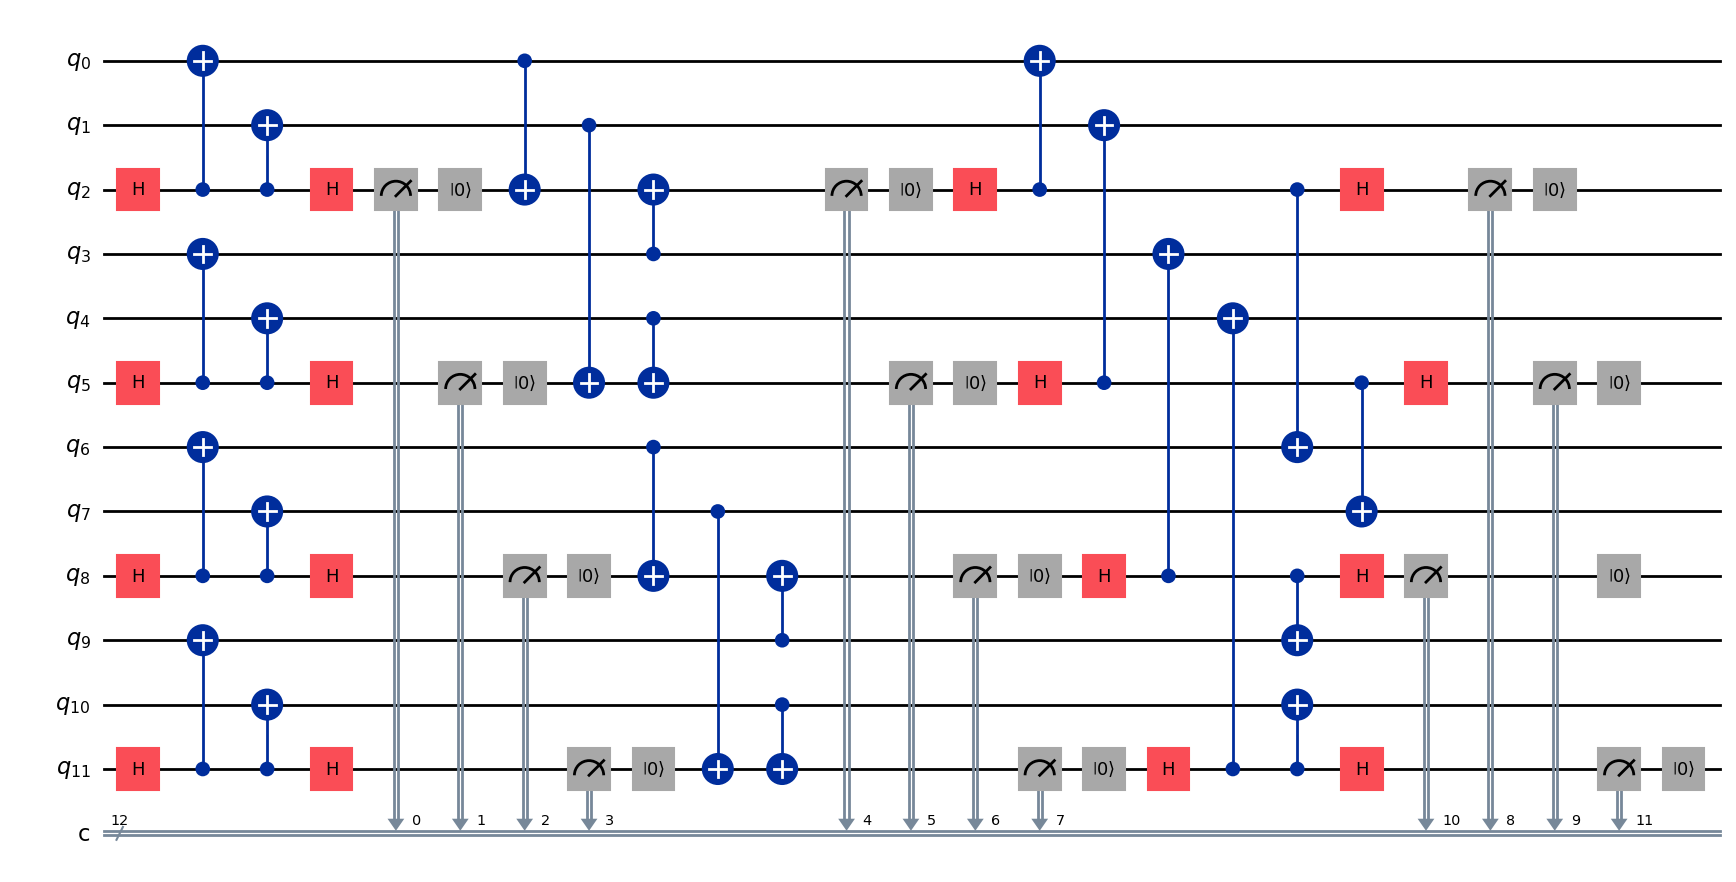

In [4]:
polar_circuits_x[3].draw("mpl", fold=30)

In [5]:
list_circuit_name

['polar_z_n3',
 'polar_z_n4',
 'polar_z_n5',
 'polar_z_n6',
 'polar_x_n3',
 'polar_x_n4',
 'polar_x_n5',
 'polar_x_n6']

In [6]:
# polar_circuits[5].draw("mpl", idle_wires=False,fold=-1)

In [7]:
list_2q = []
list_x = []
list_depth = []
list_2q_depth = []

for i in range(3,7):
    for op in polar_circuits[i].count_ops().items():
        if(op[0] == "cx"):
            list_2q.append(op[1])

    
    x_count = polar_circuits[i].count_ops()["x"] if "x" in  polar_circuits[i].count_ops() else 0 
    list_x.append(x_count)
            
    list_depth.append(polar_circuits[i].depth())
    list_2q_depth.append(polar_circuits[i].depth(lambda operation: operation.name in ['cx']))
    
for i in range(3,7):
    for op in polar_circuits_x[i].count_ops().items():
        if(op[0] == "cx"):
            list_2q.append(op[1])

    x_count = polar_circuits_x[i].count_ops()["x"] if "x" in  polar_circuits_x[i].count_ops() else 0 
    list_x.append(x_count)
    
    list_depth.append(polar_circuits_x[i].depth())
    list_2q_depth.append(polar_circuits_x[i].depth(lambda operation: operation.name in ['cx']))

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
 
token = "476ea8c61cc54f36e4a21d70a8442f94203c9d87096eaad0886a3e8154d8c2e79bcad6f927c6050a76335dd68d783f478c1b828504748a4377b441c335c831aa"
QiskitRuntimeService.save_account(channel="ibm_quantum", token=token, overwrite=True)
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.backend("ibm_kyiv")


In [9]:
list_2q_z4 = []
list_x_z4 = []
list_depth_z4 = []
list_2q_depth_z4 = []

## change later back to 3
pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

for i in range(3,7):
    circuit = polar_circuits[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "ecr"):
            list_2q_z4.append(op[1])
            
    x_count = transpiled.count_ops()["x"] if "x" in  transpiled.count_ops() else 0 
    list_x_z4.append(x_count)
    
    list_depth_z4.append(transpiled.depth())
    list_2q_depth_z4.append(transpiled.depth(lambda operation: operation.name in ['ecr']))

for i in range(3,7):
    circuit = polar_circuits_x[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "ecr"):
            list_2q_z4.append(op[1])

    x_count = transpiled.count_ops()["x"] if "x" in  transpiled.count_ops() else 0 
    list_x_z4.append(x_count)
    
    list_depth_z4.append(transpiled.depth())
    list_2q_depth_z4.append(transpiled.depth(lambda operation: operation.name in ['ecr']))


In [10]:
# polar_circuits_x[4].draw("mpl", fold=-1)

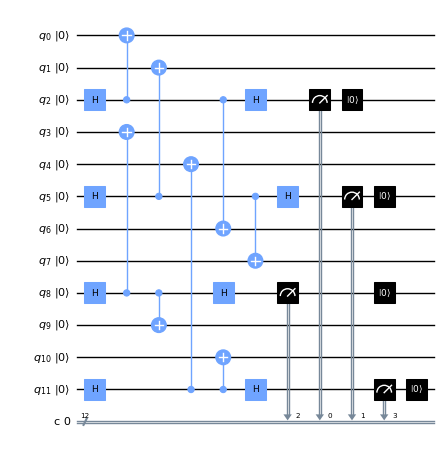

In [11]:
# circuit = QuantumCircuit(8,8)
# circuit.cx(0,1)
# circuit.cx(2,3)
# circuit.cx(4,5)
# circuit.cx(6,7)

# circuit.cx(1,2)
# circuit.cx(3,4)
# circuit.cx(5,6)

# circuit.cx(0,1)
# circuit.cx(2,3)
# circuit.cx(4,5)
# circuit.cx(6,7)

# # circuit.cx(0,5)
# # circuit.cx(1,4)
# circuit.measure_all()

circuit = polar_circuits[3]
circuit.draw("mpl", scale=0.5, style="clifford", 
             interactive=False, reverse_bits=False, justify="left",
             vertical_compression="high", with_layout=True, initial_state=True,
             expr_len=30,
             idle_wires=False, fold=-1)

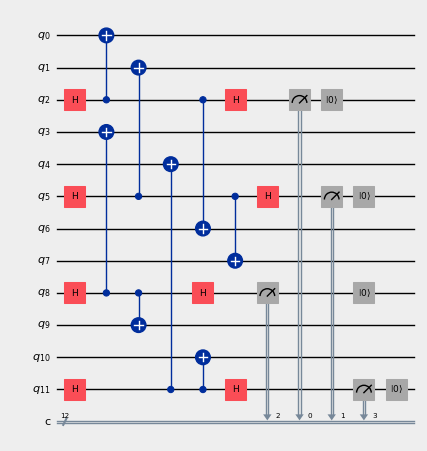

In [12]:
from qiskit.visualization import circuit_drawer
circuit_drawer(circuit, scale=0.5, output="mpl", style={"backgroundcolor": "#EEEEEE"})

In [13]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer

dag = circuit_to_dag(circuit)
dag_drawer(dag)

MissingOptionalLibraryError: "The 'Graphviz' library is required to use 'dag_drawer'.  To install, follow the instructions at https://graphviz.org/download/. Qiskit needs the Graphviz binaries, which the 'graphviz' package on pip does not install. You must install the actual Graphviz software."

In [ ]:
transpiled = pm.run(circuit)
plot_circuit_layout(transpiled, backend)

In [ ]:
from qiskit.visualization import pass_manager_drawer
# pass_manager_drawer(pm, filename="qiskit-1.png")

In [ ]:
# list_2q_z4 = []
# list_depth_z4 = []
# list_2q_depth_z4 = []

# for i in range(10):
#     circuit = polar_circuits_x[4]
#     transpiled = pm.run(circuit)
    
#     for op in transpiled.count_ops().items():
#         if(op[0] == "ecr"):
#             list_2q_z4.append(op[1])
#     list_depth_z4.append(transpiled.depth())
#     list_2q_depth_z4.append(transpiled.depth(lambda gate: gate[0].name in ['ecr']))

# print(list_2q_z4)
# print(list_depth_z4)
# print(list_2q_depth_z4)


In [ ]:
# qasm = """
# """
# circ = QuantumCircuit.from_qasm_str(qasm)

# for op in circ.count_ops().items():
#     if(op[0] == "ecr"):
#         print(op[1])
# print(circ.depth())
# print(circ.depth(lambda gate: gate[0].name in ['ecr']))

In [ ]:
print(np.mean(list_2q_z4), np.mean(list_depth_z4), np.mean(list_2q_depth_z4) )

In [ ]:
df_polar = pd.DataFrame({
        'circuit_name': list_circuit_name,
        'n': list_n,
        'logical': list_logical,
        'base_2q': list_2q,
        'base_x': list_x,
        'base_depth': list_depth,
        'base_2q_depth': list_2q_depth,
        'z4_2q': list_2q_z4,
        'z4_x': list_x_z4,
        'z4_depth': list_depth_z4,
        'z4_2q_depth': list_2q_depth_z4,
    })

In [20]:
df_polar

,circuit_name,n,logical,base_2q,base_x,base_depth,base_2q_depth,z4_2q,z4_x,z4_depth,z4_2q_depth
0,polar_z_n3,3,0,8,0,6,2,8,0,17,2
1,polar_z_n4,4,0,64,0,20,8,198,28,203,49
2,polar_z_n5,5,0,64,0,12,4,97,18,62,11
3,polar_z_n6,6,0,384,0,30,12,2908,458,1440,359
4,polar_x_n3,3,+,24,0,16,6,54,8,96,22
5,polar_x_n4,4,+,48,0,16,6,118,14,141,34
6,polar_x_n5,5,+,160,0,26,10,752,117,602,146
7,polar_x_n6,6,+,320,0,26,10,1782,266,948,232


# Noisy Simulator

In [24]:
qc = polar_circuits_x_meas_data[3]
n = 3
lstate = "X"

## CX Error

In [116]:
def generate_sim_noise_cx(backend, noise_level, method="automatic"):
    noise_cx = NoiseModel()
    p_gate1 = noise_level
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)
    noise_cx.add_all_qubit_quantum_error(error_gate2, ["cx"])
    noise_cx.add_all_qubit_quantum_error(error_gate2, ["ecr"])

    sim_noise_cx = AerSimulator(method=method, noise_model=noise_cx)
    # sim_noise_cx = AerSimulator(method="extended_stabilizer", noise_model=noise_cx)
    # sim_noise_cx = AerSimulator(noise_model=noise_cx, configuration=backend.configuration())
    sim_noise_cx.set_options(
        noise_model=noise_cx,
        coupling_map=backend.configuration().coupling_map
    )

    return sim_noise_cx


In [118]:
sim_noise_cx = generate_sim_noise_cx(backend, 0.05)
counts = sim_noise_cx.run(qc, shots = 10000).result().get_counts()
count_accept, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts)
print(count_accept)

4539


## Readout Error

In [129]:
def generate_sim_noise_readout(backend, noise_level, method="automatic"):
    noise_model = NoiseModel()
    
    # Measurement misassignment probabilities
    p0given1 = noise_level
    p1given0 = noise_level
    readout_error = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

    noise_model.add_all_qubit_readout_error(readout_error)

    sim_noise = AerSimulator(method=method, noise_model=noise_model)
    
    sim_noise.set_options(
        noise_model=noise_model,
        coupling_map=backend.configuration().coupling_map
    )

    return sim_noise

In [135]:
sim_noise_ro = generate_sim_noise_readout(backend, 0.04)
counts = sim_noise_ro.run(qc, shots = 10000).result().get_counts()
count_accept, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts)
print(count_accept)

6493


## Depolarizing Error

In [149]:
# Create an empty noise model
noise_model = NoiseModel()
 
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.01, 2)
noise_model.add_all_qubit_quantum_error(error, ["cx"])
 


In [218]:
sim_noise = AerSimulator(noise_model=noise_model)
counts = sim_noise.run(qc, shots = 10000, seed_simulator=12345).result().get_counts()
count_accept, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts)
print(count_accept)

10000


6935


## Combine Everything 

In [108]:
def simulate_polar_code_with_noise(noise_type, backend, circuit, n, lstate):

    result = {}
    for i in range(0, 501, 5):
        noise_level = i / 1000
        
        if noise_type == "cx":
            sim_noise = generate_sim_noise_cx(backend, noise_level)

        counts = sim_noise.run(circuit, shots = 10000).result().get_counts()

        count_accept, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts)

        result[noise_level] = count_accept

    return result

In [ ]:
result_cx = simulate_polar_code_with_noise("cx", backend, polar_circuits_x_meas_data[3], 3, "X")

In [109]:
df_cx = pd.DataFrame(list(result_cx.items()), columns=['noise_value', 'count_accept'])
df_cx.head()

,noise_value,count_accept
0,0.000,10000
1,0.005,9056
2,0.010,8254
3,0.015,7537
4,0.020,6894


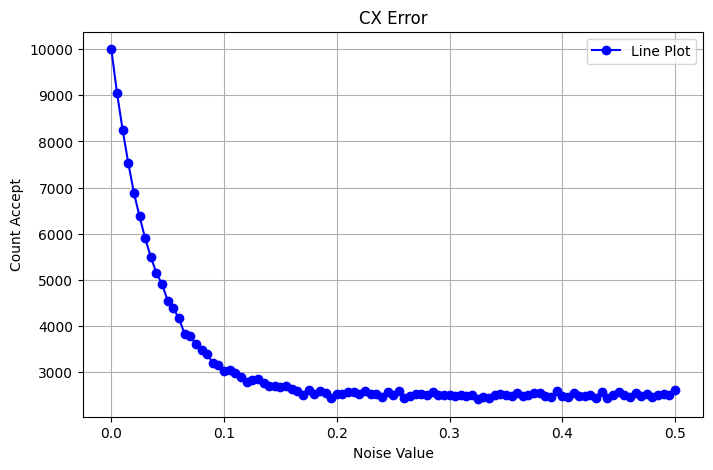

In [110]:
# Line plot
plt.figure(figsize=(8, 5))
plt.plot(df_cx['noise_value'], df_cx['count_accept'], marker='o', linestyle='-', color='b', label="Line Plot")
plt.xlabel("Noise Value")
plt.ylabel("Count Accept")
plt.title("CX Error")
plt.legend()
plt.grid(True)
plt.show()

# From Noise Model Backend Breakdown

In [20]:
noise_model_backend = NoiseModel.from_backend(backend)
dict = noise_model_backend.to_dict()

list_operation = []
for er in dict["errors"]:
    list_operation.append(er["operations"][0])

list_operation_unique = list(set(list_operation))
list_operation_unique

['x', 'reset', 'ecr', 'sx', 'id', 'measure']

In [14]:
qc = polar_circuits_x_meas_data[3]
n = 3
lstate = "X"

In [15]:
# qasm_str = """
# OPENQASM 2.0;
# include "qelib1.inc";
# qreg q[5];
# creg c[5];
# x q[0];
# x q[1];
# x q[2];
# x q[3];
# u3(0,0,-pi/4) q[3];
# u3(pi/2,0,pi) q[4];
# cx q[3],q[4];
# u3(0,0,pi/4) q[4];
# cx q[3],q[4];
# u3(0,0,-pi/4) q[4];
# u3(pi/2,0,pi) q[4];
# u3(pi/2,0,pi) q[4];
# u3(pi/2,0,pi) q[3];
# u3(0,0,pi/4) q[3];
# cx q[2],q[3];
# u3(0,0,-pi/4) q[3];
# u3(pi/2,0,pi) q[3];
# cx q[0],q[3];
# u3(0,0,pi/4) q[3];
# cx q[1],q[3];
# u3(0,0,-pi/4) q[3];
# cx q[0],q[3];
# u3(0,0,pi/4) q[3];
# cx q[1],q[3];
# u3(0,0,-pi/4) q[3];
# u3(pi/2,0,pi) q[3];
# u3(0,0,pi/4) q[3];
# cx q[2],q[3];
# u3(0,0,-pi/4) q[3];
# u3(pi/2,0,pi) q[3];
# u3(0,0,pi/4) q[3];
# cx q[3],q[4];
# u3(0,0,-pi/4) q[4];
# cx q[3],q[4];
# u3(0,0,pi/4) q[4];
# u3(pi/2,0,pi) q[4];
# u2(0,pi) q[4];
# u3(pi/2,-2*pi,pi) q[3];
# u3(0,0,pi/4) q[3];
# cx q[2],q[3];
# u3(0,0,-pi/4) q[3];
# u3(pi/2,-2*pi,pi) q[3];
# u3(0,0,pi/4) q[3];
# cx q[1],q[3];
# u3(0,0,-pi/4) q[3];
# cx q[0],q[3];
# u3(0,0,pi/4) q[3];
# cx q[1],q[3];
# u3(0,0,-pi/4) q[3];
# cx q[0],q[3];
# u1(-pi/16) q[0];
# cx q[0],q[4];
# u1(pi/16) q[4];
# cx q[0],q[4];
# u1(-pi/16) q[4];
# u2(0,pi) q[4];
# u2(0,pi) q[4];
# cx q[0],q[1];
# u1(pi/16) q[1];
# cx q[1],q[4];
# u1(-pi/16) q[4];
# cx q[1],q[4];
# u1(pi/16) q[4];
# u2(0,pi) q[4];
# u2(0,pi) q[4];
# cx q[0],q[1];
# u1(-pi/16) q[1];
# cx q[1],q[4];
# u1(pi/16) q[4];
# cx q[1],q[4];
# u1(-pi/16) q[4];
# u2(0,pi) q[4];
# u2(0,pi) q[4];
# u3(pi/2,-2*pi,pi) q[3];
# u3(0,0,pi/4) q[3];
# cx q[2],q[3];
# cx q[1],q[2];
# u1(pi/16) q[2];
# cx q[2],q[4];
# u1(-pi/16) q[4];
# cx q[2],q[4];
# u1(pi/16) q[4];
# u2(0,pi) q[4];
# u2(0,pi) q[4];
# cx q[0],q[2];
# u1(-pi/16) q[2];
# cx q[2],q[4];
# u1(pi/16) q[4];
# cx q[2],q[4];
# u1(-pi/16) q[4];
# u2(0,pi) q[4];
# u2(0,pi) q[4];
# cx q[1],q[2];
# u1(pi/16) q[2];
# cx q[2],q[4];
# u1(-pi/16) q[4];
# cx q[2],q[4];
# u1(pi/16) q[4];
# u2(0,pi) q[4];
# u2(0,pi) q[4];
# cx q[0],q[2];
# u1(-pi/16) q[2];
# cx q[2],q[4];
# u1(pi/16) q[4];
# cx q[2],q[4];
# u1(-pi/16) q[4];
# u2(0,pi) q[4];
# u3(0,0,-pi/4) q[3];
# u3(pi/2,-2*pi,pi) q[3];
# measure q[0] -> c[0];
# measure q[1] -> c[1];
# measure q[2] -> c[2];
# measure q[3] -> c[3];
# measure q[4] -> c[4];"""
# qc = QuantumCircuit.from_qasm_str(qasm_str)

In [16]:
tqc = pm.run(qc) # the circuit has been compiled, I don't have to think about coupling map in the noise_model
tqc.count_ops()

OrderedDict([('rz', 234),
             ('sx', 134),
             ('ecr', 57),
             ('measure', 20),
             ('reset', 12),
             ('x', 5)])

In [21]:
def get_noise_model_backend_by_gates(backend, operation_name):
    noise_model_backend = NoiseModel.from_backend(backend)
    
    dict = noise_model_backend.to_dict()
    list_error = []
    for er in dict["errors"]:
        if operation_name in er["operations"]:
            list_error.append(er)

    dict_error = {"errors": list_error}
    noise_model = NoiseModel.from_dict(dict_error)

    return noise_model

In [22]:
def get_count_accept_by_noise_model_by_gates(backend, operation_name, shots, seed_simulator):
    noise_model = get_noise_model_backend_by_gates(backend, operation_name)
    sim_noise = AerSimulator(configuration=backend.configuration(),
                             method="automatic", 
                             noise_model=noise_model
                            )
    counts = sim_noise.run(tqc, shots = shots, seed_simulator=seed_simulator).result().get_counts()
    
    count_accept, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts)

    return count_accept

In [20]:
seed_simulator = 12345
shots = 4000
count_accept_breakdown = {}
for key in tqc.count_ops().keys():
    count_accept_breakdown[key] = get_count_accept_by_noise_model_by_gates(backend, key, shots, seed_simulator)


/tmp/ipykernel_13455/1156577178.py:11: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(dict_error)
/tmp/ipykernel_13455/1156577178.py:11: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(dict_error)
/tmp/ipykernel_13455/1156577178.py:11: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(dict_error)
/tmp/ipykernel_13455/1156577178.py:11: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(dict_error)
/tmp/ipykernel_13455/1156577178.py:11: DeprecationWarning: from_dict has bee

In [21]:
count_accept_breakdown

{'rz': 4000,
 'sx': 3867,
 'ecr': 2589,
 'measure': 3689,
 'x': 3983,
 'reset': 4000}

In [22]:
shots = 4000

In [23]:
# seed simulation = 12345

prep_rate_breakdown = {}
for key, value in count_accept_breakdown.items():
    prep_rate_breakdown[key] = value / shots

prep_rate_breakdown["all"] = 2011 / shots
prep_rate_breakdown

{'rz': 1.0,
 'sx': 0.96675,
 'ecr': 0.64725,
 'measure': 0.92225,
 'x': 0.99575,
 'reset': 1.0,
 'all': 0.50275}

In [53]:
df_breakdown = pd.DataFrame(list(prep_rate_breakdown.items()), columns=['operation_name', 'count_accept'])

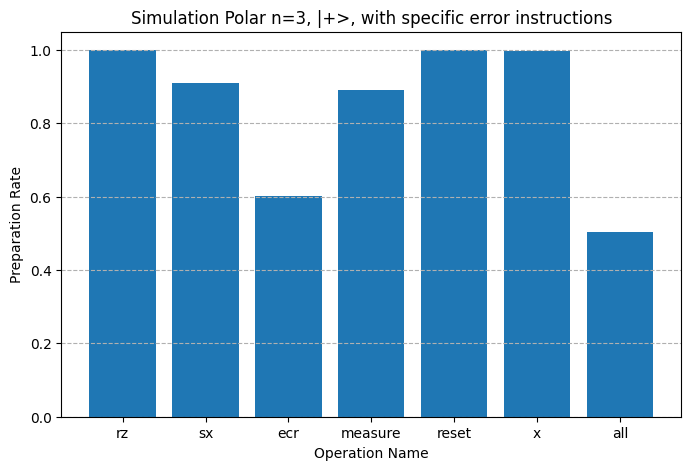

In [55]:
# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(df_breakdown['operation_name'], df_breakdown['count_accept'])
plt.xlabel("Operation Name")
plt.ylabel("Preparation Rate")
plt.title("Simulation Polar n=3, |+>, with specific error instructions")
plt.grid(axis='y', linestyle='--')
plt.savefig(f"polar_n3_x_sim_12345_error_breakdown_kyiv.png", dpi=500)
plt.show()

### Playing with Duration

In [432]:
noise_model_ecr = get_noise_model_backend_by_gates(backend, "ecr")

/tmp/ipykernel_8691/1156577178.py:11: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(dict_error)


In [437]:
sim_noise_ecr = AerSimulator(noise_model=noise_model)
sim_noise_ecr.set_options(
        noise_model=noise_model,
        coupling_map=backend.configuration().coupling_map
    )

In [572]:
sim_noise_ecr.instruction_durations
# There is no instruction duration if we changed it to dictionary

## Noisy simulator all from backend

In [31]:
fake_backend = AerSimulator.from_backend(backend)

In [50]:
counts = fake_backend.run(tqc, shots=4000,seed_simulator=12345).result().get_counts()    

count_accept, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts)

In [51]:
count_accept

2011

In [36]:
used_qbs = used_qubits(tqc)

In [642]:
# dir(fake_backend)
# dir(fake_backend.instruction_durations)

In [643]:
# fake_backend.instruction_durations.update([("ecr", (66,67), 2500000)])
# fake_backend.instruction_durations.update([("ecr", (67,66), 2500000)])
# fake_backend.instruction_durations.update([("ecr", (67,68), 2500000)])
# fake_backend.instruction_durations.update([("ecr", (68,69), 2500000)])
# fake_backend.instruction_durations.get("ecr", (68,69))

### From my function

In [644]:
from qiskit.providers.models import BackendProperties

/tmp/ipykernel_8691/500874065.py:1: DeprecationWarning: qiskit.providers.models is deprecated since Qiskit 1.2 and will be removed in Qiskit 2.0. With the removal of Qobj, there is no need for these schema-conformant objects. If you still need to use them, it could be because you are using a BackendV1, which is also deprecated in favor of BackendV2.
  from qiskit.providers.models import BackendProperties


In [645]:
def get_noisy_simulator(backend, 
                        error_percentage: float = 1, 
                        noiseless: bool = False, 
                        method: str ="automatic"):
    _backend = copy.deepcopy(backend)
    _properties = _backend.properties()
    _prop_dict = _properties.to_dict()
    
    # update readout error
    for i in _prop_dict["qubits"]:
        for j in i:
            if (j["name"] in ("readout_error", "prob_meas0_prep1", "prob_meas1_prep0")):
                new_val = j["value"] * error_percentage
                if new_val > 1:
                    new_val = 1
                j["value"] = new_val
                # j["value"] = 0
                # print(j["name"], j["value"])
            elif (j["name"] in ("T1", "T2")):
                if error_percentage == 0:
                    new_val = j["value"]  / 0.00001
                else:
                    new_val = j["value"]  / error_percentage
                
                j["value"] = new_val

    # print(_prop_dict["qubits"][0])
    
    # update single qubit error
    for i in _prop_dict["gates"]:
        if(i["gate"] != "ecr"):
            pars = i["parameters"]
        
            for par in pars:
                if (par["name"] == "gate_error"):
                    new_val = par["value"] * error_percentage
                    if new_val > 1:
                        new_val = 1
                    # par["value"] = new_val
                    par["value"] = 0
                    # print(i["qubits"], par["value"])
    
    # Update Two Qubit Error
    for i in _prop_dict["gates"]:
        if(i["gate"] == "ecr"):
            pars = i["parameters"]
    
            for par in pars:
                if (par["name"] == "gate_error"):
                    new_val = par["value"] * error_percentage
                    if new_val > 1:
                        new_val = 1
                    par["value"] = new_val
                    # print(i["qubits"], par["value"])
    
    new_properties = BackendProperties.from_dict(_prop_dict)
    new_prop_dict = new_properties.to_dict()
    new_prop_json = json.dumps(new_prop_dict, indent = 0, default=str) 
    new_prop_json = new_prop_json.replace("\n", "")

    coupling_map = _backend.configuration().coupling_map
    # print(coupling_map)
    
    
    
    if backend.name in (["ibm_fez", "ibm_marrakesh", "ibm_torino"]):
        if noiseless or error_percentage == 0.0:
            sim_noisy = AerSimulator()
        else:
            sim_noisy = AerSimulator.from_backend(backend=backend)

        return None, sim_noisy, coupling_map

    else:
        noise_model = NoiseModel.from_backend_properties(new_properties, dt = 0.1)
        if noiseless or error_percentage == 0.0:
            sim_noisy = AerSimulator()
        else:
            sim_noisy = AerSimulator(configuration=_backend.configuration(), properties=new_properties,
                                    noise_model=noise_model, method = method
                                    # max_shot_size=100,method='statevector', max_memory_mb=10000 
                                    )
            sim_noisy.set_options(
                noise_model=noise_model,
                method = method
                # max_shot_size=100, max_memory_mb=10000, method='statevector'
                )
    
        return noise_model, sim_noisy, coupling_map


In [646]:
noise_model, sim_noisy, coupling_map = get_noisy_simulator(backend, 1, False)

In [647]:
counts_my_fun = sim_noisy.run(tqc, shots=4000,seed_simulator=12345).result().get_counts()    
counts_my_fun
# count_accept_my_fun, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts_my_fun)
# count_accept_my_fun

{'00010': 2,
 '00100': 2,
 '01100': 9,
 '10100': 2,
 '10110': 15,
 '01011': 57,
 '01110': 34,
 '01000': 1,
 '00110': 14,
 '11001': 12,
 '11111': 2841,
 '01111': 276,
 '11101': 76,
 '00111': 96,
 '00011': 49,
 '11011': 79,
 '01010': 6,
 '00001': 1,
 '10010': 6,
 '11100': 5,
 '10101': 9,
 '10111': 211,
 '11110': 75,
 '01101': 39,
 '10011': 53,
 '00101': 8,
 '10001': 4,
 '11010': 13,
 '01001': 5}

### Noise Model from Backend + adding thermal noise

In [648]:
fake_backend = AerSimulator.from_backend(backend)
noise_model_backend = NoiseModel.from_backend(backend)

In [649]:
used_qbs = used_qubits(tqc)

In [650]:
# dir(fake_backend)

In [651]:
# dir(fake_backend.properties())

In [652]:
prop_dict = backend.properties().to_dict()

In [653]:
# prop_dict

In [719]:
list_T1 = []
list_T2 = []
measure_length = 0
for i in prop_dict["qubits"]:
    for j in i:
        if (j["name"] in ("T1")):
            list_T1.append(j["value"] * 1000000)
        if (j["name"] in ("T2")):
            list_T2.append(j["value"] * 1000000)
        if (j["name"] in ("readout_length")):
            measure_length = j["value"] * 1000
    

gates_length = {}

for key in tqc.count_ops().keys():
    for i in prop_dict["gates"]:
        if(i["gate"] == key):
            pars = i["parameters"]
            for par in pars:
                if par["name"] == "gate_length":
                    gates_length[key] = par["value"] * 1000

gates_length["measure"] = measure_length
            
gates_length

{'rz': 0,
 'sx': 56888.88888888888,
 'ecr': 533333.3333333333,
 'x': 56888.88888888888,
 'measure': 1216000}

In [762]:
errors_thermal = {}

for key in tqc.count_ops().keys():
    if key != "ecr":
        errors_thermal[key] = [
        thermal_relaxation_error(t1, t2, gates_length[key]) for t1, t2 in zip(list_T1, list_T2)
    ]
    else:
        errors_thermal[key] = [
        [
            thermal_relaxation_error(t1a, t2a, time_cx).expand(
                thermal_relaxation_error(t1b, t2b, gates_length[key])
            )
            for t1a, t2a in zip(list_T1, list_T2)
        ]
        for t1b, t2b in zip(list_T1, list_T2)
    ]

errors_thermal["delay"] = errors_thermal["sx"]

In [763]:
list_edges_used = []

for i in backend.coupling_map.get_edges():
    for q in used_qbs:
        if q in i:
            list_edges_used.append(i)

list_edges_used = list(set(list_edges_used))

In [764]:
noise_thermal = NoiseModel()
# # noise_thermal = noise_model_backend
for key in tqc.count_ops().keys():
    if key != "ecr":
        for q in used_qbs:
            noise_thermal.add_quantum_error(errors_thermal[key][q], key, [q])
    else:
        for j,k in list_edges_used:
            noise_thermal.add_quantum_error(errors_thermal[key][j][k], key, [j, k])

for q in used_qbs:
    noise_thermal.add_quantum_error(errors_thermal["delay"][q], "delay", [q])

In [765]:
sim_noise_thermal = AerSimulator(noise_model=noise_thermal)
counts_thermal = sim_noise_thermal.run(tqc, shots=4000,seed_simulator=12345).result().get_counts()    

counts_thermal
# counts_thermal, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts_thermal)

{'01010': 1,
 '10110': 1,
 '11110': 19,
 '11001': 3,
 '11111': 3447,
 '11011': 70,
 '00011': 8,
 '00111': 50,
 '01011': 56,
 '10111': 119,
 '10101': 7,
 '11101': 59,
 '01101': 52,
 '01111': 86,
 '10011': 11,
 '01110': 2,
 '10001': 2,
 '00101': 2,
 '11010': 1,
 '01001': 4}

In [766]:
counts_thermal["11111"] / 4000

0.86175

In [767]:
def apply_pad_delay(qc, backend):
    target = backend.target
    
    delay_pm = PassManager(
        [
            ALAPScheduleAnalysis(target=target),
            PadDelay(target=target),
        ]
        )

    return delay_pm.run(qc)

In [768]:
tqc_delay = apply_pad_delay(tqc, backend)
counts_thermal_delay = sim_noise_thermal.run(tqc_delay, shots=4000,seed_simulator=12345).result().get_counts()    

counts_thermal_delay["11111"] / 4000


0.85425

In [769]:
from qiskit_ibm_runtime.options import SamplerOptions, EstimatorOptions, DynamicalDecouplingOptions, TwirlingOptions
from qiskit.circuit.library import XGate, YGate, ZGate, RZGate

def apply_dd(
            circuit: QuantumCircuit, 
            backend, 
            dd_options: DynamicalDecouplingOptions = {"enable":False}
            ):

        sequence_type = dd_options["sequence_type"]
        scheduling_method = dd_options["scheduling_method"]

        X = XGate()
        Y = YGate()
        Z = ZGate()
        RZ = RZGate(np.pi)
        
        if sequence_type == "XX":
            dd_sequence = [X, X]
        elif sequence_type == "XpXm":
            dd_sequence = [X, X]
        elif sequence_type == "XY4":
            dd_sequence = [X, X, RZ, X, RZ, X]

        target = backend.target

        # Set the scheduling method
        if scheduling_method == "alap":
            scheduling = ALAPScheduleAnalysis(target=target)
        elif scheduling_method == "asap":
            scheduling = ASAPScheduleAnalysis(target=target)

        dd_pm = PassManager(
        [
            scheduling,
            PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence),
        ]
        )
        
        circuit_dd = dd_pm.run(circuit)

        return circuit_dd

In [770]:
tqc_dd = apply_dd(tqc, backend, {"enable":True, "sequence_type":"XX", "scheduling_method":"alap"})
counts_thermal_dd = sim_noise_thermal.run(tqc_dd, shots=4000,seed_simulator=12345).result().get_counts()    

counts_thermal_dd["11111"] / 4000

0.8395

In [718]:
tqc.count_ops()

OrderedDict([('rz', 180), ('sx', 102), ('ecr', 52), ('x', 15), ('measure', 5)])

In [708]:
tqc_dd.count_ops()

OrderedDict([('delay', 228),
             ('rz', 180),
             ('sx', 102),
             ('x', 75),
             ('ecr', 52),
             ('measure', 5)])

## Mitigate Measurement Error with M3

In [23]:
backend = service.backend("ibm_sherbrooke")

In [24]:
shots = 5000
noise_model = get_noise_model_backend_by_gates(backend, "measure")
sim_noise = AerSimulator(configuration=backend.configuration(), noise_model=noise_model)


/tmp/ipykernel_5143/1156577178.py:11: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.15.0 and will be removed no earlier than 3 months from that release date.
  noise_model = NoiseModel.from_dict(dict_error)


In [25]:
fake_backend = AerSimulator.from_backend(backend)
# counts = fake_backend.run(tqc, shots = shots, seed_simulator=12345).result().get_counts()

In [26]:
qc = polar_circuits_x_meas_data[3]
tqc = pm.run(qc)
# tqc.draw("mpl", idle_wires=False)

In [33]:
counts = sim_noise.run(tqc, shots = shots).result().get_counts()
count_accept, _, _, fidelity, _, _  = get_logical_error_on_accepted_states(n, lstate, counts)


In [34]:
print(count_accept / shots, fidelity)

0.6704 0.5217780429594272


In [51]:
new_counts_connector = {}
for key, value in counts.items():
    #print(key)
    #print(key[0:8], key[-12:], value)
    #new_counts_m3[key[-12:]] = key[0:8]
    new_counts_connector[key[-12:]] = []
    #break

for key, value in counts.items():
    #print(key)
    #print(key[0:8], key[-12:], value)
    #new_counts_m3[key[-12:]] = key[0:8]
    new_counts_connector[key[-12:]].append(key[0:8])


In [52]:
new_counts_connector

{'010100000011': ['01001001',
  '10111011',
  '10011110',
  '01011010',
  '00010001',
  '10100100',
  '00000000',
  '00101101',
  '11000011',
  '01110011'],
 '010111110111': ['11111101', '11001011'],
 '001000001000': ['00100110',
  '10100101',
  '01100110',
  '01111000',
  '11110011',
  '10010110'],
 '000011110011': ['00011110',
  '01000100',
  '11110000',
  '11010010',
  '10110110',
  '10101010',
  '11000011',
  '00100010',
  '10101000',
  '11000010',
  '00011000',
  '01001011'],
 '100000000010': ['11111111',
  '01101101',
  '10011001',
  '11110000',
  '00000011',
  '00111100'],
 '011011001001': ['11000000', '11100010', '01000111', '01100101'],
 '101100111011': ['11010001',
  '11110011',
  '10010101',
  '11100010',
  '01100101',
  '11101100',
  '01011001',
  '10001011',
  '00100001'],
 '110100110010': ['11001111', '00101110', '11110011'],
 '001011110111': ['10011001',
  '01001001',
  '10110100',
  '10001000',
  '10111010',
  '00011010',
  '00000111'],
 '101111111000': ['10011001',
  '

In [36]:
mappings = mthree.utils.final_measurement_mapping(tqc)
print(mappings)

mappings = {key: value for idx, (key, value) in enumerate(mappings.items()) if idx < 12 }
print(mappings, len(mappings))

{0: 1, 1: 18, 2: 33, 3: 41, 4: 1, 5: 18, 6: 33, 7: 41, 8: 0, 9: 33, 10: 19, 11: 41, 12: 2, 13: 1, 14: 18, 15: 40, 16: 14, 17: 39, 18: 20, 19: 53}
{0: 1, 1: 18, 2: 33, 3: 41, 4: 1, 5: 18, 6: 33, 7: 41, 8: 0, 9: 33, 10: 19, 11: 41} 12


In [49]:
new_counts_ancilla = sum_middle_digits_dict(counts, -12, None)
new_counts_data = sum_middle_digits_dict(counts, 0, 8)

mit = mthree.M3Mitigation(sim_noise)
mit.cals_from_system(mappings, 100000)
m3_quasi = mit.apply_correction(new_counts_ancilla, mappings)

In [ ]:
# this is to connect the data back

new_counts_m3 = {}
for key, value in counts.items():
    #print(key)
    #print(key[0:8], key[-12:], value)
    #new_counts_m3[key[-12:]] = key[0:8]
    new_counts_m3[key[-12:]] = []
    #break

for key, value in counts.items():
    #print(key)
    #print(key[0:8], key[-12:], value)
    #new_counts_m3[key[-12:]] = key[0:8]
    new_counts_m3[key[-12:]].append(key[0:8])


In [38]:
m3_quasi_count = {key: round(value * shots) for key, value in m3_quasi.items()}
count_accept_m3 = get_q1prep_sr(n, lstate, m3_quasi_count)
count_accept_m3

0.8720605819051415

In [44]:
new_counts_corrected = {}
for key, value in m3_quasi_count.items():
    print(key, value)
    new_key = f"{new_counts_m3[key]}{key}"
    new_counts_corrected[new_key] = value
    print(new_key, value)
    break

new_counts_corrected

000000000000 6
01110111000000000000 6


{'01110111000000000000': 6}

In [46]:
counts["01110111000000000000"]

1

In [41]:
new_counts_m3["000000000000"]

'01110111'

In [66]:
#m3_quasi = mit.apply_correction(counts, mappings)
#m3_quasi_count = {key: round(value * shots) for key, value in m3_quasi.items()}

M3Error: 'Bitstring length (20) does not match number of qubits (12)'

In [31]:
def apply_m3_correction(qc, pm, noisy_sim, shots, seed_simulator=None):
    
    tqc = pm.run(qc)
    
    counts = noisy_sim.run(tqc, shots = shots, seed_simulator=seed_simulator).result().get_counts()
    count_accept, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, counts)
    # count_accept = get_q1prep_sr(n, lstate, counts)

    mappings = mthree.utils.final_measurement_mapping(tqc)
    
    mappings = {key: value for idx, (key, value) in enumerate(mappings.items()) if idx < 12 }
    
    mit = mthree.M3Mitigation(noisy_sim)
    
    # to increase the precision, increase the number of shots here.
    job = mit.cals_from_system(mappings, 100000)
    
    m3_quasi = mit.apply_correction(counts, mappings)
    m3_quasi_count = {key: round(value * shots) for key, value in m3_quasi.items()}
    # count_accept_m3, _, _, _, _, _  = get_logical_error_on_accepted_states(n, lstate, m3_quasi_count)
    count_accept_m3 = get_q1prep_sr(n, lstate, m3_quasi_count)

    return count_accept, count_accept_m3
    

In [32]:
# only with measurement error

list_prep_rate = []
list_prep_rate_m3 = []

for i in range(10):
    prep_rate, prep_rate_m3 = apply_m3_correction(qc, pm, sim_noise, 5000, seed_simulator=None)

    print(f"({i}) prep_rate: {prep_rate}, prep_rate_m3: {prep_rate_m3}")
    
    list_prep_rate.append(prep_rate)
    list_prep_rate_m3.append(prep_rate_m3)

M3Error: 'Bitstring length (20) does not match number of qubits (12)'

In [ ]:
print(f"Average: prep_rate: {np.mean(list_prep_rate)}, prep_rate_m3: {np.mean(list_prep_rate_m3)}")

In [ ]:
# with all noise error
list_prep_rate = []
list_prep_rate_m3 = []

for i in range(10):
    prep_rate, prep_rate_m3 = apply_m3_correction(qc, pm, fake_backend, 5000, seed_simulator=None)

    print(f"({i}) prep_rate: {prep_rate}, prep_rate_m3: {prep_rate_m3}")
    
    list_prep_rate.append(prep_rate)
    list_prep_rate_m3.append(prep_rate_m3)

In [ ]:
print(f"Average: prep_rate: {np.mean(list_prep_rate)}, prep_rate_m3: {np.mean(list_prep_rate_m3)}")

# Simulate Idle Error

In [324]:
def apply_pad_delay(qc, backend):
    target = backend.target
    
    delay_pm = PassManager(
        [
            ALAPScheduleAnalysis(target=target),
            PadDelay(target=target),
        ]
        )

    return delay_pm.run(qc)

In [389]:
def create_circuit_ghz_with_delay(delay_dt):
    qc_idle = QuantumCircuit(3,3)
    qc_idle.delay(delay_dt,0)
    qc_idle.delay(delay_dt,1)
    qc_idle.delay(delay_dt,2)
    qc_idle.barrier([0,1,2])
    qc_idle.h(0)
    qc_idle.delay(delay_dt,0)
    qc_idle.delay(delay_dt,1)
    qc_idle.delay(delay_dt,2)
    qc_idle.barrier([0,1,2])
    qc_idle.cx(0,1)
    qc_idle.delay(delay_dt,0)
    qc_idle.delay(delay_dt,1)
    qc_idle.delay(delay_dt,2)
    qc_idle.barrier([0,1,2])
    qc_idle.cx(1,2)
    qc_idle.delay(delay_dt,0)
    qc_idle.delay(delay_dt,1)
    qc_idle.delay(delay_dt,2)

    qc_idle.barrier([0,1,2])
    
    qc_idle.measure([0,1,2],[0,1,2])
    
    return qc_idle


In [390]:
qc_idle = create_circuit_ghz_with_delay(1000)
tqc_idle = transpile(qc_idle, backend=backend, optimization_level=0, layout_method="trivial", scheduling_method='alap')
job = fake_backend.run(tqc_idle, shots=10000,seed_simulator=12345)
job.result().get_counts()

{'101': 437,
 '100': 150,
 '001': 102,
 '000': 4332,
 '010': 398,
 '110': 112,
 '011': 167,
 '111': 4302}

In [391]:
dt = backend.dt
zz_rate = 1000000

In [392]:
from qiskit.circuit import Barrier
from qiskit.circuit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZZGate, RZGate

In [393]:
def add_rzz_to_delays_dd_normal(qc, zz_rate, dt):
    num_x = 0
    dag = circuit_to_dag(qc)
    new_dag = dag.copy_empty_like()
    barriers_id = [br._node_id for br in dag.op_nodes(Barrier)]
    print(barriers_id)
    for dn in dag.topological_op_nodes():
        if dn.name == 'delay':
            if dn._node_id > barriers_id[0] and dn._node_id < barriers_id[1]:
                if dn.qargs[0] == dag.qubits[0]:
                    dur = dn.op.duration
                    new_dag.apply_operation_back(RZZGate(dur * zz_rate * dt), [dag.qubits[0], dag.qubits[1]])
                    new_dag.apply_operation_back(dn.op, [dag.qubits[1]])
                    if num_x < 2:
                        # new_dag.apply_operation_back(XGate(), [dag.qubits[1]])
                        num_x += 1
                if dn.qargs[0] == dag.qubits[1]:
                    continue
        if dn.name == 'x':
            if dn._node_id > barriers_id[0] and dn._node_id < barriers_id[1]:
                if dn.qargs[0] == dag.qubits[1]:
                    continue
        new_dag.apply_operation_back(dn.op, dn.qargs, dn.cargs)
    return dag_to_circuit(new_dag)

In [394]:
new_qc_idle = add_rzz_to_delays_dd_normal(qc_idle, zz_rate, dt)
new_tqc_idle = transpile(new_qc_idle, backend=backend, optimization_level=0, layout_method="trivial", scheduling_method='alap')
job = fake_backend.run(new_tqc_idle, shots=10000,seed_simulator=12345)
job.result().get_counts()

[15, 20, 25, 30]


/tmp/ipykernel_8691/3509629971.py:24: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  return dag_to_circuit(new_dag)
/tmp/ipykernel_8691/3509629971.py:24: DeprecationWarning: The property ``qiskit.dagcircuit.dagcircuit.DAGCircuit.unit`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  return dag_to_circuit(new_dag)


{'101': 432,
 '100': 155,
 '001': 145,
 '000': 4290,
 '010': 392,
 '110': 159,
 '011': 172,
 '111': 4255}

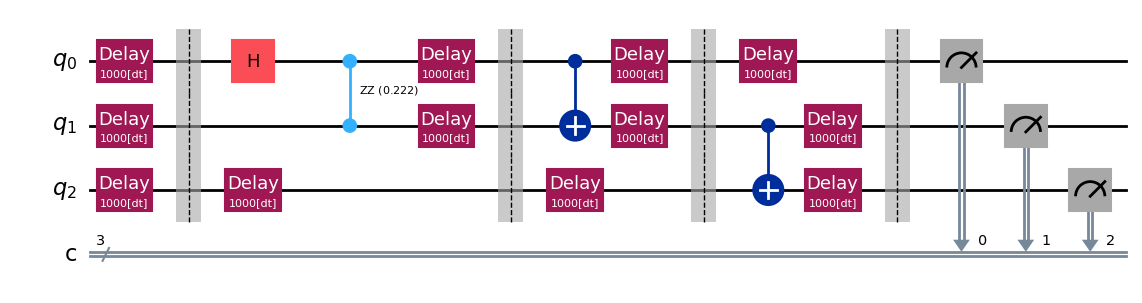

In [395]:
new_qc_idle.draw("mpl")

In [396]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(
    50e3, 10e3, 4
)  # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(
    70e3, 10e3, 4
)  # Sampled from normal distribution mean 50 microsec
 
# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])
 
# Instruction times (in nanoseconds)
time_u1 = 0  # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100  # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000  # 1 microsecond
 
# QuantumError objects
errors_reset = [
    thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)
]
errors_measure = [
    thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)
]
errors_u1 = [
    thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)
]
errors_u2 = [
    thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)
]
errors_u3 = [
    thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)
]
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(
            thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]
 
# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
 
print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['cx', 'measure', 'u3', 'reset', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


In [397]:
thermal_dict = noise_thermal.to_dict()

In [399]:
thermal_dict["errors"][]

[{'type': 'qerror',
  'id': '7b885d08a7d44fbd920f1567db19be91',
  'operations': ['reset'],
  'instructions': [[{'name': 'kraus',
     'qubits': [0],
     'params': [array([[-0.99895047+0.j,  0.        +0.j],
             [ 0.        +0.j, -0.98796735+0.j]]),
      array([[-0.04580355+0.j,  0.        +0.j],
             [ 0.        +0.j,  0.04631274+0.j]]),
      array([[0.        +0.j, 0.14756576+0.j],
             [0.        +0.j, 0.        +0.j]])]}]],
  'probabilities': [np.float64(1.0)],
  'gate_qubits': [(0,)]},
 {'type': 'qerror',
  'id': '3860d5c4391c4a0a86dd863f4881da88',
  'operations': ['reset'],
  'instructions': [[{'name': 'kraus',
     'qubits': [0],
     'params': [array([[-0.99900019+0.j,  0.        +0.j],
             [ 0.        +0.j, -0.98593779+0.j]]),
      array([[-0.04470583+0.j,  0.        +0.j],
             [ 0.        +0.j,  0.04529812+0.j]]),
      array([[0.        +0.j, 0.16085629+0.j],
             [0.        +0.j, 0.        +0.j]])]}]],
  'probabilities':

# Adding ZZ Error

In [23]:
def used_qubits(qc):
    """
    Parameter: 
    circuit (QuantumCircuit)
        
    Returns: list: indices of the qubits used in the circuit
    """
    L=qc.num_qubits
    used_qb=[]
    qct=transpile(qc,optimization_level=0,basis_gates=['cx','rx','rz','x'])
    for gate in qct:
        if gate.name=='rx' or gate.name=='rz' or gate.name=='x':
            if gate.qubits[0]._index not in used_qb:
                used_qb.append(gate.qubits[0]._index)
        if gate.name=='cx':
            if gate.qubits[0]._index not in used_qb:
                used_qb.append(gate.qubits[0]._index)
            if gate.qubits[1]._index not in used_qb:
                used_qb.append(gate.qubits[1]._index)
    return used_qb

def neighbours(qb_index,coupling_map):
    """
    Parameters: 
    integer: index of a qubit 
    list: coupling map of the backend (same format as in Qiskit)
        
    Returns: list: indices of neighbouring qubits of qb_index
    """
    neigh=[]
    for qb_1,qb_2 in coupling_map:
        if qb_1==qb_index and qb_2 not in neigh:
            neigh.append(qb_2)
        if qb_2==qb_index and qb_1 not in neigh:
            neigh.append(qb_1)
    return neigh

def CNOT_used(qc,coupling_map):
    """
    Parameters: 
    circuit (QuantumCircuit)
    list: coupling map of the backend (same format as in Qiskit)
        
    Return: list: indices of possible CNOT used in the circuit
    """
    list_CNOT=[]
    qct=transpile(qc,optimization_level=0,basis_gates=['cx','rx','rz','x'])
    for gate in qct:
        if gate.name=='cx':
            qb_ctrl = gate.qubits[0]._index
            qb_trgt = gate.qubits[1]._index
            
            if (qb_ctrl,qb_trgt) not in list_CNOT:
                list_CNOT.append([qb_ctrl,qb_trgt])
 
    return (list_CNOT)

def neighbours_CNOT_used(qb_ctrl,qb_trgt,qc,coupling_map):
    """
    Parameters: 
    integer: index of the control qubit of the CNOT
    integer: index of the target qubit of the CNOT
    circuit (QuantumCircuit)
    list: coupling map of the backend (same format as in Qiskit)
        
    Return: list: neighbouring qubits of the CNOT used in the circuit
    """
    neigh_ctrl=neighbours(qb_ctrl,coupling_map)
    neigh_trgt=neighbours(qb_trgt,coupling_map)
    used_qb=used_qubits(qc)
    neigh_CNOT=[]
    for qb in used_qb:
        if qb!=qb_ctrl and qb!=qb_trgt and (qb in neigh_ctrl or qb in neigh_trgt):
            neigh_CNOT.append(qb)
    return neigh_CNOT  

In [24]:
pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)
qc = polar_circuits[3]
tqc = pm.run(qc)


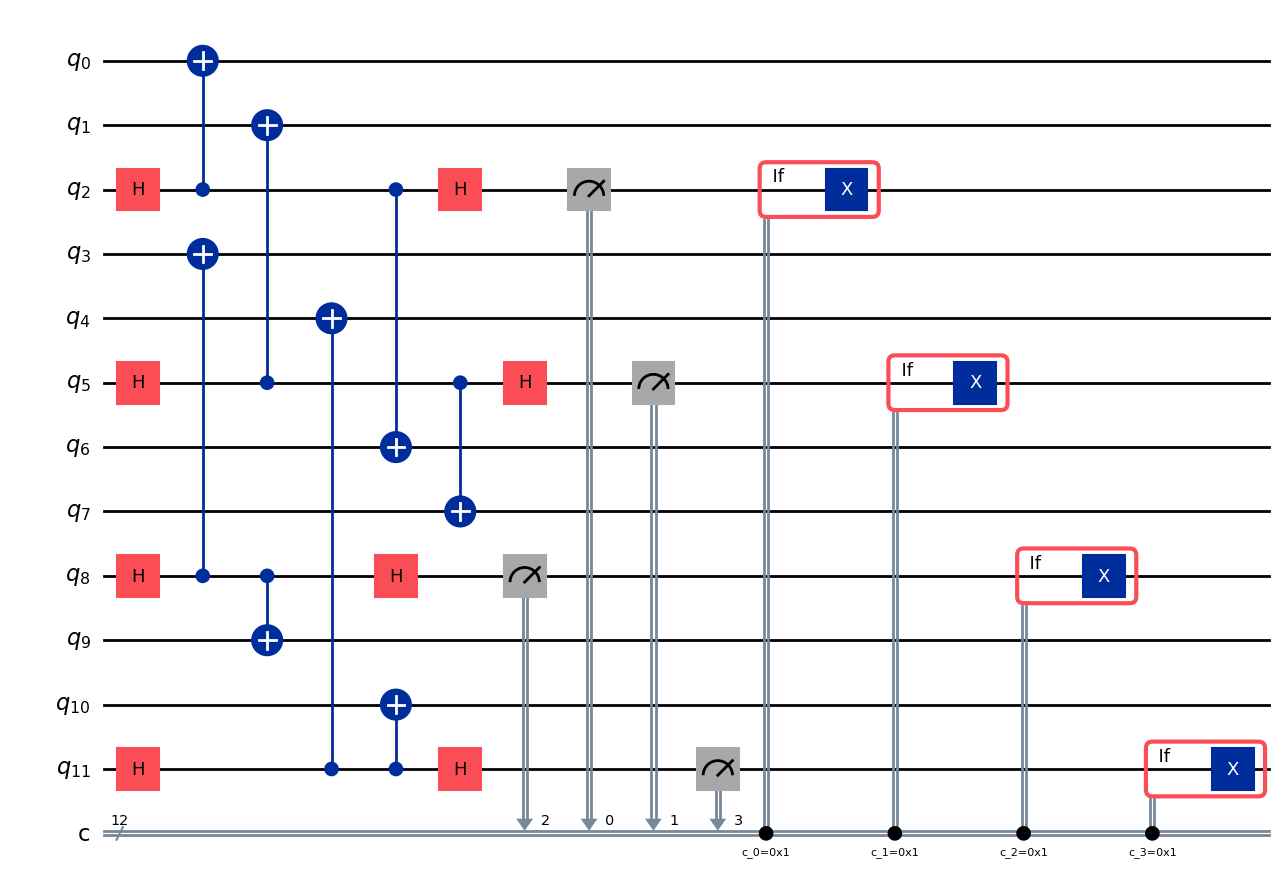

In [25]:
qc.draw("mpl", idle_wires=False)

In [26]:
def avoid_simultaneous_cnot(tqc, backend, type="ctrl"):
    dag = circuit_to_dag(tqc)
    layers = dag.layers()
    new_dag = dag.copy_empty_like()
    cm = backend.configuration().coupling_map
    used_qubit_prev_layer = []

    list_neighbours_qubits={}
    for i in range(127):
        list_neighbours_qubits[i] = neighbours(i,cm)

    
    for lay in layers:
        g = lay["graph"]

        tmp_circ = dag_to_circuit(g)
        cx_q = CNOT_used(tmp_circ, cm)

        list_neighbours_CNOT={}
        for qb_ctrl,qb_trgt in cx_q:
            list_neighbours_CNOT[qb_ctrl,qb_trgt]=neighbours_CNOT_used(qb_ctrl,qb_trgt,tmp_circ,cm)

        dict_neighbour_cx = {}
        unique_data = {}
        
        if len(g.collect_2q_runs()) > 0:
           
            for i in g.collect_2q_runs():
                op = i[0]
                op_name = op.op.name
                qb_ctrl = op.qargs[0]
                qb_trgt = op.qargs[1]
            
                if op_name == "ecr":
                    for qb_pairs, qb_nghrs in list_neighbours_CNOT.items():
                        if qb_ctrl._index in qb_nghrs: 
                            if qb_pairs[0] in list_neighbours_qubits[qb_ctrl._index]:
                                dict_neighbour_cx[qb_ctrl] = dag.qubits[qb_pairs[0]]
                            elif qb_pairs[1] in list_neighbours_qubits[qb_ctrl._index]:
                                dict_neighbour_cx[qb_ctrl] = dag.qubits[qb_pairs[1]]
                        
                        elif qb_trgt._index in qb_nghrs:
                            if qb_pairs[0] in list_neighbours_qubits[qb_trgt._index]:
                                dict_neighbour_cx[qb_trgt] = dag.qubits[qb_pairs[0]]
                            elif qb_pairs[1] in list_neighbours_qubits[qb_trgt._index]:
                                dict_neighbour_cx[qb_trgt] = dag.qubits[qb_pairs[1]]

        for key, value in dict_neighbour_cx.items():
            if key not in unique_data.values() and key not in unique_data.keys():
                unique_data[value] = key  # This ensures only the last key with the same value is kept

        
        
        # print(unique_data)
        for dn in g.topological_op_nodes():
            if dn.name == "ecr":
                
                qb_ctrl = dn.qargs[0]
                qb_trgt = dn.qargs[1]
            
                # print(qb_ctrl, qb_trgt)
        
                if qb_ctrl in unique_data.keys() or qb_trgt in unique_data.keys():
                    if qb_ctrl._index in used_qubit_prev_layer:
                        # new_dag.apply_operation_back(XGate(), [qb_ctrl])
                        # new_dag.apply_operation_back(XGate(), [qb_ctrl])
                        new_dag.apply_operation_back(IGate(), [qb_ctrl])
                    elif qb_trgt._index in used_qubit_prev_layer:
                        # new_dag.apply_operation_back(XGate(), [qb_trgt])
                        # new_dag.apply_operation_back(XGate(), [qb_trgt])
                        new_dag.apply_operation_back(IGate(), [qb_trgt])
                        
                    # if type == "ctrl":
                    #     new_dag.apply_operation_back(XGate(), [qb_ctrl])
                    #     new_dag.apply_operation_back(XGate(), [qb_ctrl])
                    # else:
                    #     new_dag.apply_operation_back(XGate(), [qb_trgt])
                    #     new_dag.apply_operation_back(XGate(), [qb_trgt])

                # if qb_trgt in unique_data.keys():
                #     if type == "ctrl":
                #         new_dag.apply_operation_back(XGate(), [qb_ctrl])
                #         new_dag.apply_operation_back(XGate(), [qb_ctrl])
                #     else:
                #         new_dag.apply_operation_back(XGate(), [qb_trgt])
                #         new_dag.apply_operation_back(XGate(), [qb_trgt])
                    

            
        
            new_dag.apply_operation_back(dn.op, dn.qargs, dn.cargs)

        tmp_circ = dag_to_circuit(g)
        used_qubit_prev_layer = used_qubits(tmp_circ)
        
        
        # for key, value in unique_data.items():
        #     print(key,value)
            # new_dag.apply_operation_back(RZZGate(100 * 1), [key, value])

        # print("---------------")
        
    new_qc = dag_to_circuit(new_dag)
    
    return new_qc

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
# add_zz_on_simultaneous_cnot(tqc, backend).draw("mpl", idle_wires=False)

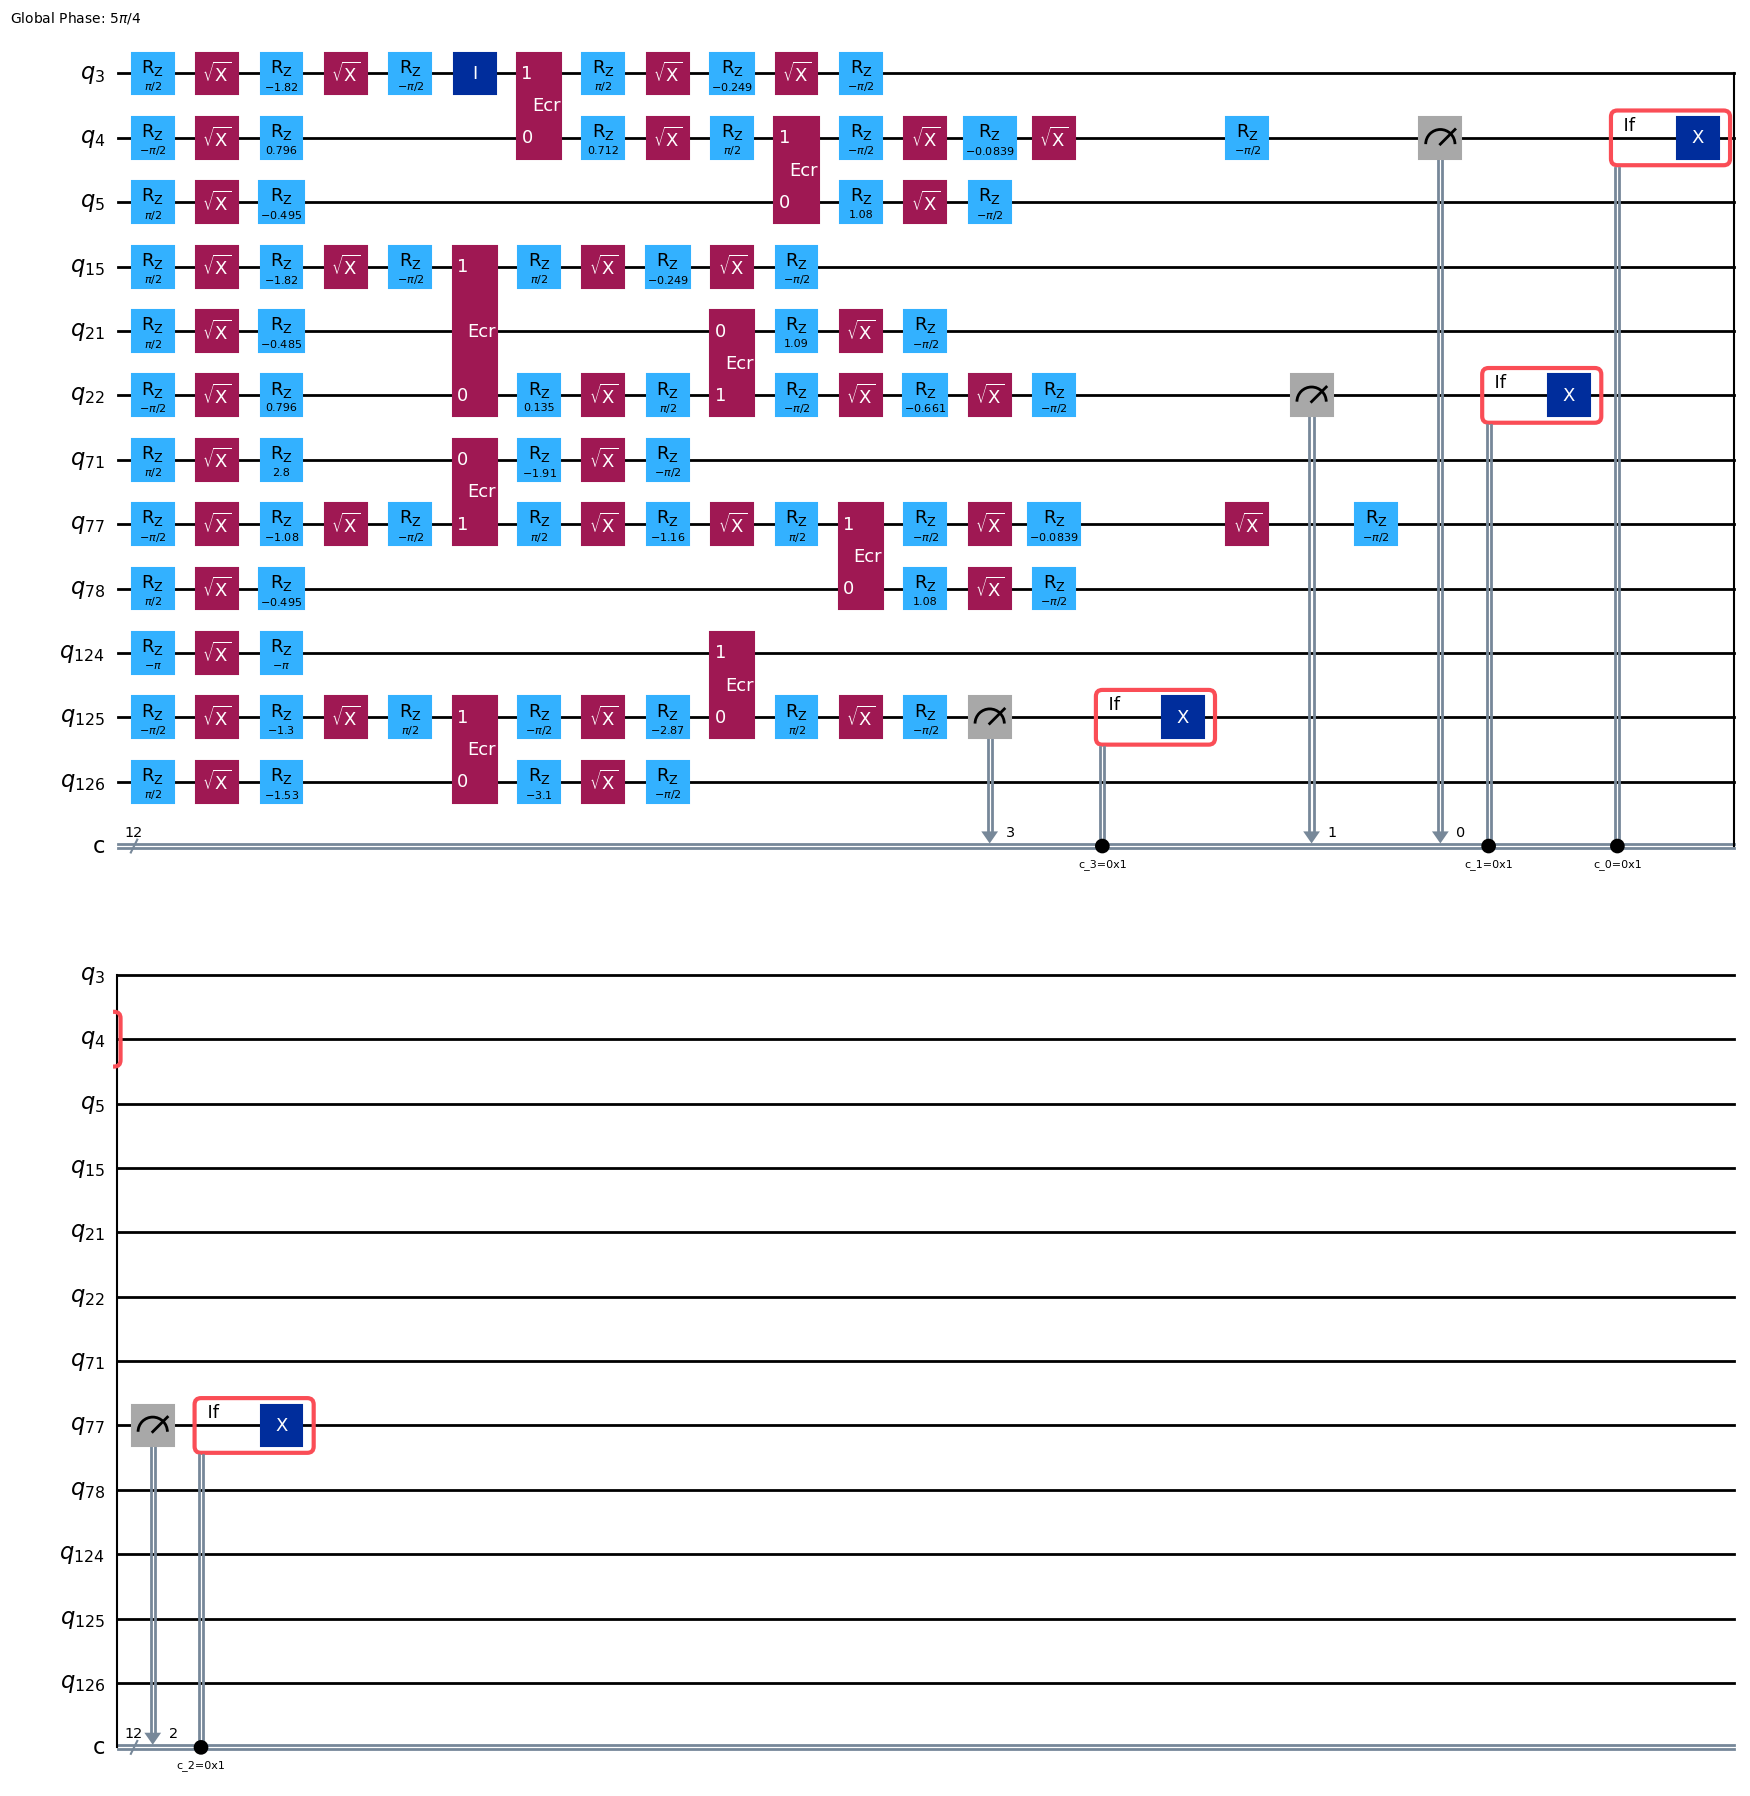

In [29]:
clean_tqc = avoid_simultaneous_cnot(tqc, backend, "ctrl")
clean_tqc.draw("mpl", idle_wires=False)

In [30]:
clean_tqc = avoid_simultaneous_cnot(clean_tqc,backend, "trgt")
clean_tqc = avoid_simultaneous_cnot(clean_tqc,backend)

In [31]:
# clean_tqc.draw("mpl", idle_wires=False)

In [32]:
def add_zz_on_simultaneous_cnot(tqc, backend):
    dag = circuit_to_dag(tqc)
    layers = dag.layers()
    new_dag = dag.copy_empty_like()
    cm = backend.configuration().coupling_map

    list_neighbours_qubits={}
    for i in range(127):
        list_neighbours_qubits[i] = neighbours(i,cm)
    
    for lay in layers:
        g = lay["graph"]
    
        # put back all the operations in the nodes
        for dn in g.topological_op_nodes():
            new_dag.apply_operation_back(dn.op, dn.qargs, dn.cargs)

        tmp_circ = dag_to_circuit(g)
        cx_q = CNOT_used(tmp_circ, cm)

        list_neighbours_CNOT={}
        for qb_ctrl,qb_trgt in cx_q:
            list_neighbours_CNOT[qb_ctrl,qb_trgt]=neighbours_CNOT_used(qb_ctrl,qb_trgt,tmp_circ,cm)
    
        if len(g.collect_2q_runs()) > 0:
           
            dict_neighbour_cx = {}
            
            for i in g.collect_2q_runs():
                op = i[0]
                op_name = op.op.name
                qb_ctrl = op.qargs[0]
                qb_trgt = op.qargs[1]
            
                if op_name == "ecr":
                    for qb_pairs, qb_nghrs in list_neighbours_CNOT.items():
                        if qb_ctrl._index in qb_nghrs: 
                            if qb_pairs[0] in list_neighbours_qubits[qb_ctrl._index]:
                                dict_neighbour_cx[qb_ctrl] = dag.qubits[qb_pairs[0]]
                            elif qb_pairs[1] in list_neighbours_qubits[qb_ctrl._index]:
                                dict_neighbour_cx[qb_ctrl] = dag.qubits[qb_pairs[1]]
                        
                        elif qb_trgt._index in qb_nghrs:
                            if qb_pairs[0] in list_neighbours_qubits[qb_trgt._index]:
                                dict_neighbour_cx[qb_trgt] = dag.qubits[qb_pairs[0]]
                            elif qb_pairs[1] in list_neighbours_qubits[qb_trgt._index]:
                                dict_neighbour_cx[qb_trgt] = dag.qubits[qb_pairs[1]]
            
            unique_data = {}
            for key, value in dict_neighbour_cx.items():
                if key not in unique_data.values() and key not in unique_data.keys():
                    unique_data[value] = key  # This ensures only the last key with the same value is kept
            
            # print(unique_data)
            
            for key, value in unique_data.items():
                # print(key,value)
                new_dag.apply_operation_back(RZZGate(100 * 1), [key, value])
        
        
    new_qc = dag_to_circuit(new_dag)
    
    return new_qc

In [33]:
new_tqc = add_zz_on_simultaneous_cnot(tqc, backend)
clean_new_tqc = add_zz_on_simultaneous_cnot(clean_tqc, backend)

OrderedDict([('rz', 64), ('sx', 37), ('ecr', 8), ('measure', 4), ('if_else', 4)]) 19
OrderedDict([('rz', 64), ('sx', 37), ('ecr', 8), ('measure', 4), ('if_else', 4), ('rzz', 1)]) 19
OrderedDict([('rz', 64), ('sx', 37), ('ecr', 8), ('measure', 4), ('if_else', 4), ('id', 1)]) 19
OrderedDict([('rz', 64), ('sx', 37), ('ecr', 8), ('measure', 4), ('if_else', 4), ('id', 1)]) 19


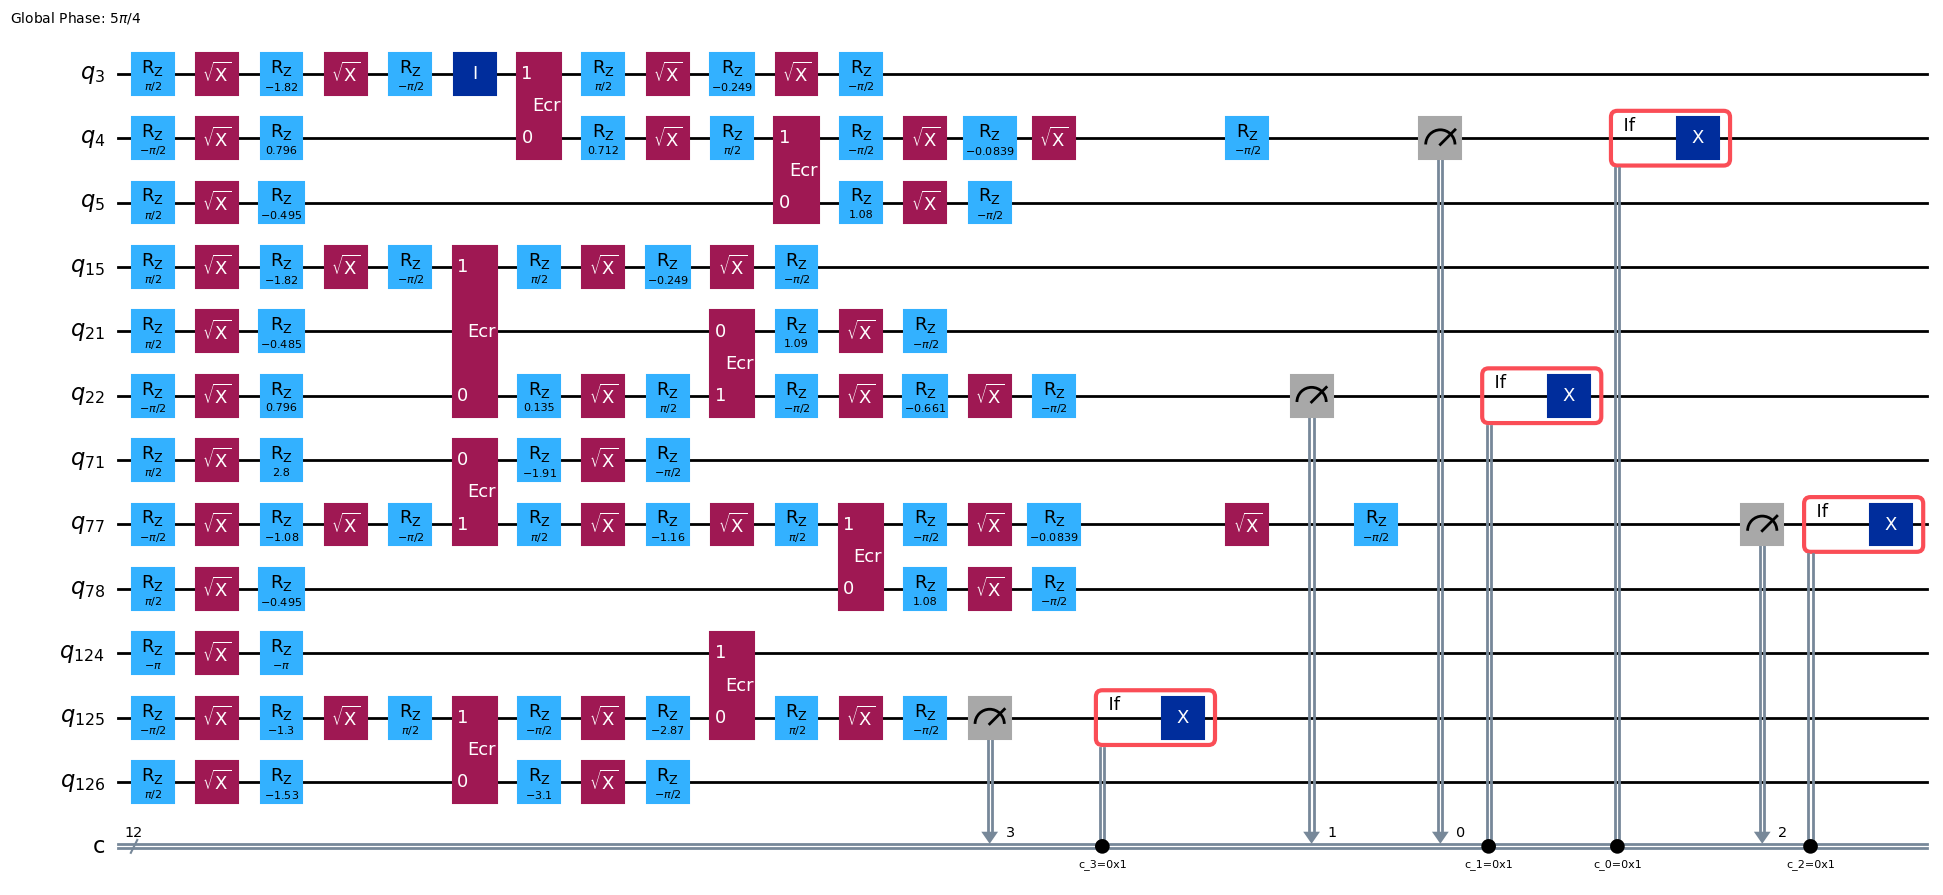

In [34]:
print(tqc.count_ops(), tqc.depth())
print(new_tqc.count_ops(), new_tqc.depth())
print(clean_tqc.count_ops(), clean_tqc.depth())
print(clean_new_tqc.count_ops(), clean_new_tqc.depth())

clean_new_tqc.draw("mpl", idle_wires=False, fold=40)

In [35]:
list_2q_z4 = []
list_x_z4 = []
list_depth_z4 = []
list_2q_depth_z4 = []

list_zz_z4 = []
list_zz_mit_z4 = []
list_zz_mit_x_z4 = []

## change later back to 3
pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

for i in range(3,7):
    circuit = polar_circuits[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "ecr"):
            list_2q_z4.append(op[1])
    list_depth_z4.append(transpiled.depth())
    list_2q_depth_z4.append(transpiled.depth(lambda operation: operation.name in ['ecr']))

    x_count = transpiled.count_ops()["x"] if "x" in  transpiled.count_ops() else 0 
    list_x_z4.append(x_count)

    tmp = add_zz_on_simultaneous_cnot(transpiled, backend)
    zz_count = tmp.count_ops()["rzz"] if "rzz" in  tmp.count_ops() else 0 
    list_zz_z4.append(zz_count)

    clean_tqc = avoid_simultaneous_cnot(transpiled,backend, "ctrl")
    clean_tqc = avoid_simultaneous_cnot(clean_tqc,backend, "trgt")
    tmp = add_zz_on_simultaneous_cnot(clean_tqc, backend)
    zz_count = tmp.count_ops()["rzz"] if "rzz" in  tmp.count_ops() else 0 
    list_zz_mit_z4.append(zz_count)

    x_count = tmp.count_ops()["id"] if "id" in  tmp.count_ops() else 0 
    list_zz_mit_x_z4.append(x_count)

for i in range(3,7):
    circuit = polar_circuits_x[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "ecr"):
            list_2q_z4.append(op[1])
    list_depth_z4.append(transpiled.depth())
    list_2q_depth_z4.append(transpiled.depth(lambda operation: operation.name in ['ecr']))

    x_count = transpiled.count_ops()["x"] if "x" in  transpiled.count_ops() else 0 
    list_x_z4.append(x_count)

    tmp = add_zz_on_simultaneous_cnot(transpiled, backend)
    zz_count = tmp.count_ops()["rzz"] if "rzz" in  tmp.count_ops() else 0 
    list_zz_z4.append(zz_count)

    clean_tqc = avoid_simultaneous_cnot(transpiled,backend, "ctrl")
    clean_tqc = avoid_simultaneous_cnot(clean_tqc,backend, "trgt")
    tmp = add_zz_on_simultaneous_cnot(clean_tqc, backend)
    zz_count = tmp.count_ops()["rzz"] if "rzz" in  tmp.count_ops() else 0 
    list_zz_mit_z4.append(zz_count)

    x_count = tmp.count_ops()["id"] if "id" in  tmp.count_ops() else 0 
    list_zz_mit_x_z4.append(x_count)

In [36]:
df_polar = pd.DataFrame({
        'circuit_name': list_circuit_name,
        'n': list_n,
        'logical': list_logical,
        # 'base_2q': list_2q,
        'base_x': list_x,
        # 'base_depth': list_depth,
        # 'base_2q_depth': list_2q_depth,
        # 'z4_2q': list_2q_z4,
        'z4_x': list_x_z4,
        # 'z4_depth': list_depth_z4,
        # 'z4_2q_depth': list_2q_depth_z4,
        'z4_zz_count': list_zz_z4,
        'z4_zz_mit': list_zz_mit_z4,
        'z4_zz_mit_id': list_zz_mit_x_z4,
    })

In [37]:
df_polar

,circuit_name,n,logical,base_x,z4_x,z4_zz_count,z4_zz_mit,z4_zz_mit_id
0,polar_z_n3,3,0,0,0,1,0,1
1,polar_z_n4,4,0,0,21,20,1,24
2,polar_z_n5,5,0,0,15,10,1,15
3,polar_z_n6,6,0,0,433,354,57,441
4,polar_x_n3,3,+,0,5,3,0,4
5,polar_x_n4,4,+,0,15,12,0,14
6,polar_x_n5,5,+,0,128,65,8,78
7,polar_x_n6,6,+,0,229,195,22,230


In [49]:
# from qiskit import QuantumCircuit, qasm2, qasm3
# program = qasm3.dumps(qc)

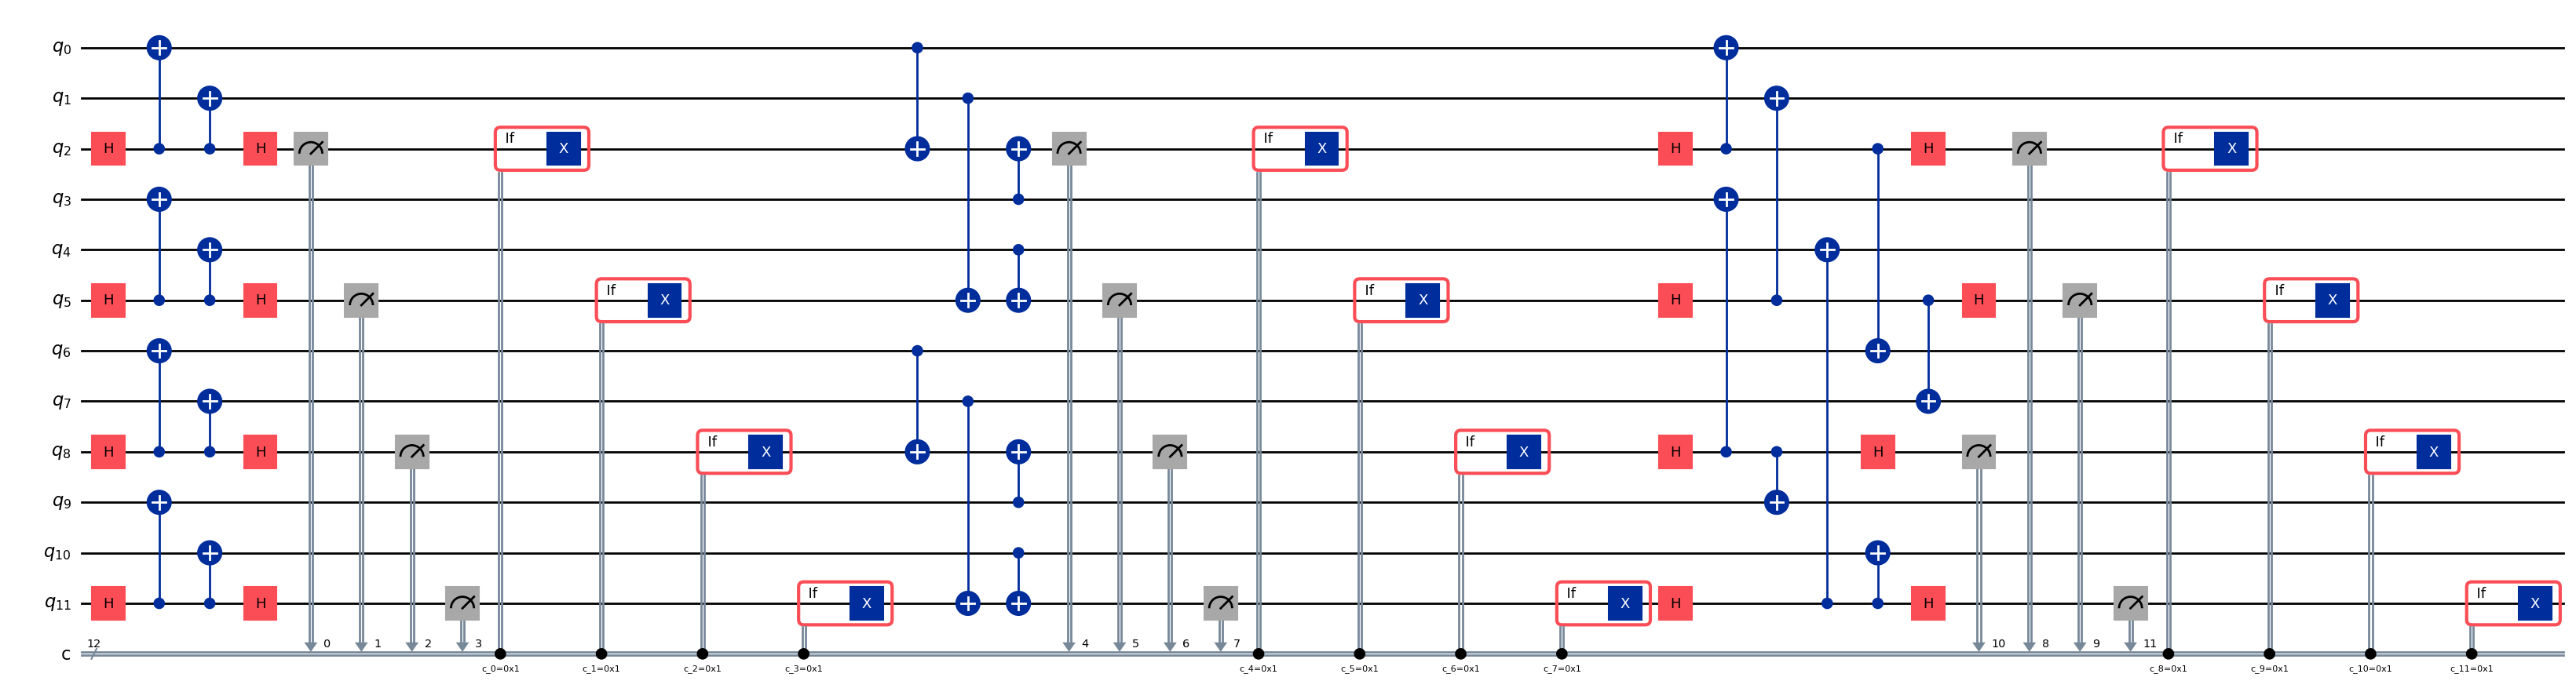

In [51]:
qc = polar_circuits_x[3]
qc.draw("mpl", fold=-1)

# Calculate Possible Error

In [39]:
def compute_total_errors(e_X, e_Z, e_CX, e_CZ, e_MX):
    """
    Compute the total X and Z errors for systems S1, S2, and S3.

    Parameters:
    e_X: dict, individual X errors {1: e_X1, 2: e_X2, 'I': e_XI}
    e_Z: dict, individual Z errors {1: e_Z1, 2: e_Z2}
    e_CX: dict, correlated X errors {('C1',1): e_CX_C1_1, ('C2',2): e_CX_C2_2, ('C1',3): e_CX_C1_3, ('C2',3): e_CX_C2_3}
    e_CZ: dict, correlated Z errors {('C1',1): e_CZ_C1_1, ('C1',3): e_CZ_C1_3, ('C2',2): e_CZ_C2_2, ('C2',3): e_CZ_C2_3}
    e_MX: additional measurement X error

    Returns:
    total_errors: dict, total X and Z errors for S1, S2, and S3
    """

    total_errors = {
        'S1': {
            'X': e_X[1] ^ e_CX[('C1', 1)],
            'Z': e_Z[1] ^ e_CZ[('C1', 1)]
        },
        'S2': {
            'X': e_X[2] ^ e_CX[('C2', 2)],
            'Z': e_Z[2] ^ e_CZ[('C1', 3)] ^ e_CZ[('C2', 2)]
        },
        'S3': {
            'X': e_X['I'] ^ e_X[1] ^ e_CX[('C1', 3)] ^ e_X[2] ^ e_CX[('C2', 3)] ^ e_MX,
            'Z': e_CZ[('C1', 3)] ^ e_CZ[('C2', 3)]
        }
    }

    return total_errors

# Example usage with dummy values
e_X_example = {1: 0, 2: 1, 'I': 0}
e_Z_example = {1: 1, 2: 0}
e_CX_example = {('C1',1): 1, ('C2',2): 0, ('C1',3): 1, ('C2',3): 0}
e_CZ_example = {('C1',1): 0, ('C1',3): 1, ('C2',2): 1, ('C2',3): 0}
e_MX_example = 1

result = compute_total_errors(e_X_example, e_Z_example, e_CX_example, e_CZ_example, e_MX_example)
print(result)

{'S1': {'X': 1, 'Z': 1}, 'S2': {'X': 1, 'Z': 0}, 'S3': {'X': 1, 'Z': 1}}


In [40]:
def compute_total_errors_xx(e_X, e_Z, e_CX, e_CZ, e_MX, e_MZ):
    """
    Compute the total X and Z errors for systems S1, S2, and S3 under Pauli X ⊗ X measurements.

    Parameters:
    e_X: dict, individual X errors {1: e_X1, 2: e_X2, 'I': e_XI}
    e_Z: dict, individual Z errors {1: e_Z1, 2: e_Z2, 'I': e_ZI}
    e_CX: dict, correlated X errors {('C1',1): e_CX_C1_1, ('C2',2): e_CX_C2_2, ('C1',3): e_CX_C1_3, ('C2',3): e_CX_C2_3}
    e_CZ: dict, correlated Z errors {('C1',1): e_CZ_C1_1, ('C1',3): e_CZ_C1_3, ('C2',2): e_CZ_C2_2, ('C2',3): e_CZ_C2_3}
    e_MX: additional measurement X error
    e_MZ: additional measurement Z error

    Returns:
    total_errors: dict, total X and Z errors for S1, S2, and S3
    """

    total_errors = {
        'S1': {
            'X': e_X[1] ^ e_CX[('C1', 1)],
            'Z': e_Z[1] ^ e_CZ[('C1', 1)]
        },
        'S2': {
            'X': e_X[2] ^ e_CX[('C2', 2)],
            'Z': e_Z[2] ^ e_CZ[('C2', 2)]
        },
        'S3': {
            'X': e_X['I'] ^ e_CX[('C1', 3)] ^ e_CX[('C2', 3)] ^ e_MX,
            'Z': e_Z['I'] ^ e_CZ[('C1', 3)] ^ e_CZ[('C2', 3)] ^ e_MZ
        }
    }

    return total_errors

# Example usage with dummy values
e_X_example = {1: 0, 2: 1, 'I': 0}
e_Z_example = {1: 1, 2: 0, 'I': 1}
e_CX_example = {('C1',1): 1, ('C2',2): 0, ('C1',3): 1, ('C2',3): 0}
e_CZ_example = {('C1',1): 0, ('C1',3): 1, ('C2',2): 1, ('C2',3): 0}
e_MX_example = 1
e_MZ_example = 0

result_xx = compute_total_errors_xx(e_X_example, e_Z_example, e_CX_example, e_CZ_example, e_MX_example, e_MZ_example)
print(result_xx)

{'S1': {'X': 1, 'Z': 1}, 'S2': {'X': 1, 'Z': 1}, 'S3': {'X': 0, 'Z': 0}}


In [41]:
def predict_error_source(measurement_result, e_X, e_Z, e_CX, e_CZ, e_MX, e_MZ):
    """
    Predicts the most likely error source based on the measurement result.
    
    Parameters:
    measurement_result: int (0 or 1), actual outcome of the measurement at S3
    (other parameters are the same as the previous function)
    
    Returns:
    suspected_errors: list of likely error sources
    """
    
    # Compute the expected measurement result
    predicted_measurement = e_X['I'] ^ e_X[1] ^ e_CX[('C1', 3)] ^ e_X[2] ^ e_CX[('C2', 3)] ^ e_MX

    suspected_errors = []
    
    # If the computed result does not match the real measurement, search for likely error sources
    if predicted_measurement != measurement_result:
        # Check which bits contribute
        if e_X['I']: suspected_errors.append("e_X^I")
        if e_X[1]: suspected_errors.append("e_X^1")
        if e_CX[('C1', 3)]: suspected_errors.append("e_CX^C1(3)")
        if e_X[2]: suspected_errors.append("e_X^2")
        if e_CX[('C2', 3)]: suspected_errors.append("e_CX^C2(3)")
        if e_MX: suspected_errors.append("e_MX")

    return suspected_errors

# Example usage with a measured result of 1
measurement_result_example = 0

suspected_sources = predict_error_source(measurement_result_example, 
                                         e_X_example, e_Z_example, 
                                         e_CX_example, e_CZ_example, 
                                         e_MX_example, e_MZ_example)

print("Suspected Error Sources:", suspected_sources)


Suspected Error Sources: ['e_CX^C1(3)', 'e_X^2', 'e_MX']


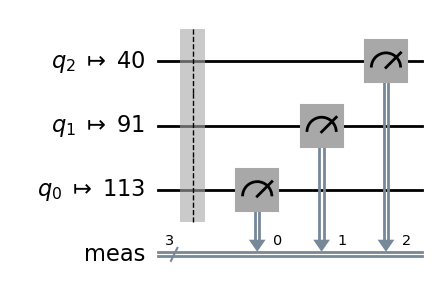

In [118]:
qc = QuantumCircuit(3)

# Z-Freezing: Set qubit 0 to |0⟩ state
# qc.initialize([0, 1], 0)  
# qc.initialize([0, 1], 1) 
# qc.initialize([0, 1], 2) 

# X-Freezing: Set qubit 1 to |+⟩ state using Hadamard
# qc.h(1)  

# Information Qubit: Qubit 2 remains unfrozen
# qc.id(2)  # Identity gate (optional, does nothing)
# qc.x(2)  # Identity gate (optional, does nothing)
# Draw the circuit
# qc.draw('mpl')

qc.measure_all()

pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)


transpiled_circuit = pm.run(qc)
transpiled_circuit.draw('mpl', idle_wires=False)

# # Plot results
# plot_histogram(counts)
# plt.show()


In [116]:
sim_noisy = AerSimulator.from_backend(backend)
# noise_model = NoiseModel.from_backend(backend)

In [117]:
job = sim_noisy.run(transpiled_circuit, shots=100000, seed=1010)
result = job.result()  
output = result.get_counts()
output

{'101': 1, '011': 3, '001': 299, '100': 433, '010': 415, '000': 98849}

In [108]:
import numpy as np

def compute_total_errors_xx(errors_x):
    """
    Compute total X errors based on XX measurement.
    errors_x: List containing X errors for each system.
    """
    e1_x, e2_x, eI_x, eC1_x, eC2_x, eM_x = errors_x
    total_x_s1 = e1_x ^ eC1_x
    total_x_s2 = e2_x ^ eC2_x
    total_x_s3 = eI_x ^ e1_x ^ eC1_x ^ e2_x ^ eC2_x ^ eM_x

    return total_x_s1, total_x_s2, total_x_s3

def compute_total_errors_zz(errors_z):
    """
    Compute total Z errors based on ZZ measurement.
    errors_z: List containing Z errors for each system.
    """
    e1_z, e2_z, eI_z, eC1_z, eC2_z, eM_z = errors_z
    total_z_s1 = e1_z ^ eC1_z
    total_z_s2 = e2_z ^ eC2_z
    total_z_s3 = eI_z ^ e1_z ^ eC1_z ^ e2_z ^ eC2_z ^ eM_z

    return total_z_s1, total_z_s2, total_z_s3

def combine_xx_zz_measurements(xx_errors, zz_errors, iterations=3):
    """
    Alternate between XX and ZZ measurements multiple times.
    """
    total_x = np.zeros(3, dtype=int)
    total_z = np.zeros(3, dtype=int)

    for i in range(iterations):
        if i % 2 == 0:  # XX measurement step
            total_x = compute_total_errors_xx(xx_errors)
            print(f"Iteration {i+1}: XX Measurement -> Total X Errors: {total_x}")
        else:  # ZZ measurement step
            total_z = compute_total_errors_zz(zz_errors)
            print(f"Iteration {i+1}: ZZ Measurement -> Total Z Errors: {total_z}")

    return total_x, total_z

# Example error values
xx_errors = [1, 1, 1, 1, 0, 1]  # Example XX errors
zz_errors = [0, 1, 1, 1, 1, 1]  # Example ZZ errors

# Run the combined measurement process
final_x_errors, final_z_errors = combine_xx_zz_measurements(xx_errors, zz_errors, iterations=5)

print(f"Final X Errors: {final_x_errors}")
print(f"Final Z Errors: {final_z_errors}")


Iteration 1: XX Measurement -> Total X Errors: (0, 1, 1)
Iteration 2: ZZ Measurement -> Total Z Errors: (1, 0, 1)
Iteration 3: XX Measurement -> Total X Errors: (0, 1, 1)
Iteration 4: ZZ Measurement -> Total Z Errors: (1, 0, 1)
Iteration 5: XX Measurement -> Total X Errors: (0, 1, 1)
Final X Errors: (0, 1, 1)
Final Z Errors: (1, 0, 1)


# Custom Backend

source: https://docs.quantum.ibm.com/guides/custom-backend

## Fake grid backend (z = 5)

In [51]:
import numpy as np
import rustworkx as rx
 
from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate, ECRGate, CXGate, HGate
from qiskit.circuit import Measure, Delay, Parameter, Reset
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_gate_map
 
 
class FakeGridBackend(BackendV2):
    """Fake grid backend."""
 
    def __init__(self, rows=3, cols=3):

        super().__init__(name="Fake grid backend")
        # Create a heavy-hex graph using the rustworkx library, then instantiate a new target
        self._graph = rx.generators.directed_grid_graph(rows, cols)
        num_qubits = len(self._graph)
        self._target = Target(
            "Fake grid backend", num_qubits=num_qubits
        )
        number_of_chips = 1
 
        # Generate instruction properties for single qubit gates and a measurement, delay,
        #  and reset operation to every qubit in the backend.
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
 
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1),
                duration=rng.uniform(1e-8, 9e-7),
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        # self._target.add_instruction(HGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)
 
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        
        # Add chip local 2q gate which is CX
        cx_props = {}
        for i in range(number_of_chips):
            for root_edge in self._graph.edge_list():
                edge = (root_edge[0], root_edge[1])
                cx_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3),
                    duration=rng.uniform(1e-8, 9e-7),
                )
        self._target.add_instruction(CXGate(), cx_props)
 
 
    @property
    def target(self):
        return self._target
 
    @property
    def max_circuits(self):
        return None
 
    @property
    def graph(self):
        return self._graph
 
    @classmethod
    def _default_options(cls):
        return Options(shots=1024)
 
    def run(self, circuit, **kwargs):
        raise NotImplementedError(
            "This backend does not contain a run method"
        )

In [52]:
rows = 8
cols = 8
backend_grid = FakeGridBackend(rows, cols)
 
 
target = backend_grid.target
coupling_map_backend = target.build_coupling_map()

coordinates = []

for i in range(0,-1 * cols,-1):
    for j in range(rows):
        coordinates.append((i,j))
 
single_qubit_coordinates = []
total_qubit_coordinates = []
 
 
for coordinate in coordinates:
    total_qubit_coordinates.append(coordinate)
 
for coordinate in coordinates:
    total_qubit_coordinates.append(
        (-1 * coordinate[0] + 1, coordinate[1] + 4)
    )
 
for coordinate in coordinates:
    total_qubit_coordinates.append((coordinate[0], coordinate[1] + 8))
 
 
line_colors = ["#adaaab" for edge in coupling_map_backend.get_edges()]
ecr_edges = []
 
# Get tuples for the edges which have an ecr instruction attached
for instruction in target.instructions:
    if instruction[0].name == "ecr":
        ecr_edges.append(instruction[1])
 
for i, edge in enumerate(coupling_map_backend.get_edges()):
    if edge in ecr_edges:
        line_colors[i] = "#000000"

Fake grid backend


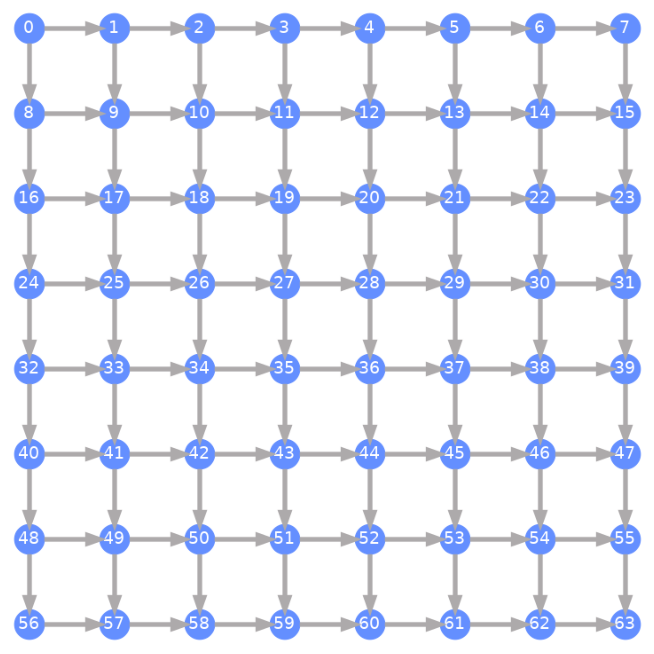

In [53]:
print(backend_grid.name)
plot_gate_map(
    backend_grid,
    plot_directed=True,
    qubit_coordinates=coordinates,
    line_color=line_colors,
)

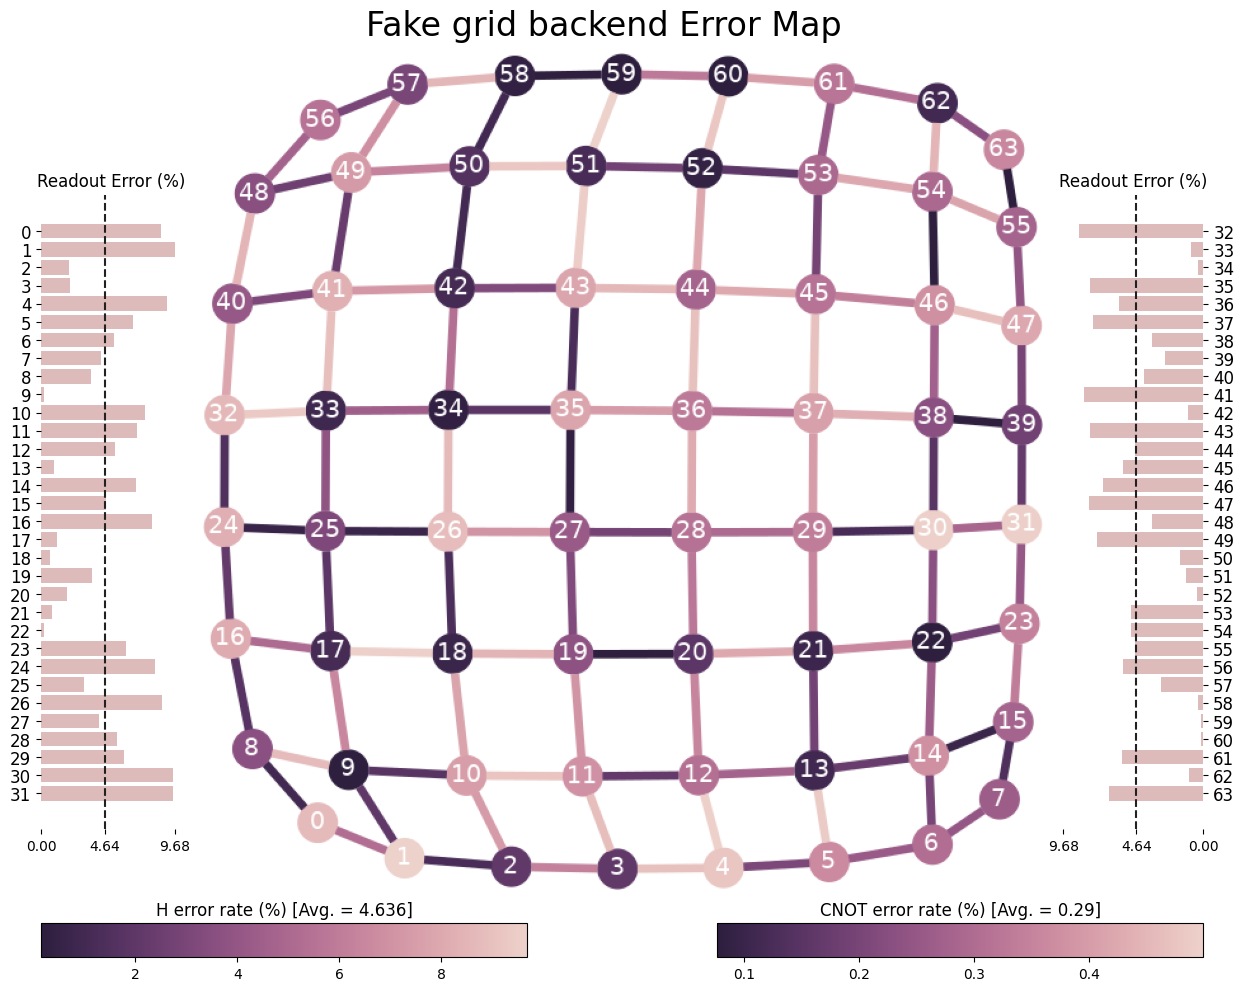

In [54]:
from qiskit.visualization import plot_error_map
 
plot_error_map(backend_grid, figsize=(15, 12))

In [42]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

circ = polar_circuits_x[3]
op_counts = circ.count_ops()
 
print("Pre-Transpilation: ")
print(f"CX gates: {op_counts['cx']}")
print(f"H gates: {op_counts['h']}")
print("\n", 30 * "#", "\n")
 
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_grid)
transpiled_circ = pm.run(circ)
op_counts = transpiled_circ.count_ops()
 
print("Post-Transpilation: ")
# print(f"CZ gates: {op_counts['cz']}")
# print(f"ECR gates: {op_counts['ecr']}")
print(f"CX gates: {op_counts['cx']}")
print(f"SX gates: {op_counts['sx']}")
print(f"RZ gates: {op_counts['rz']}")

Pre-Transpilation: 
CX gates: 24
H gates: 16

 ############################## 

Post-Transpilation: 
CX gates: 33
SX gates: 50
RZ gates: 77


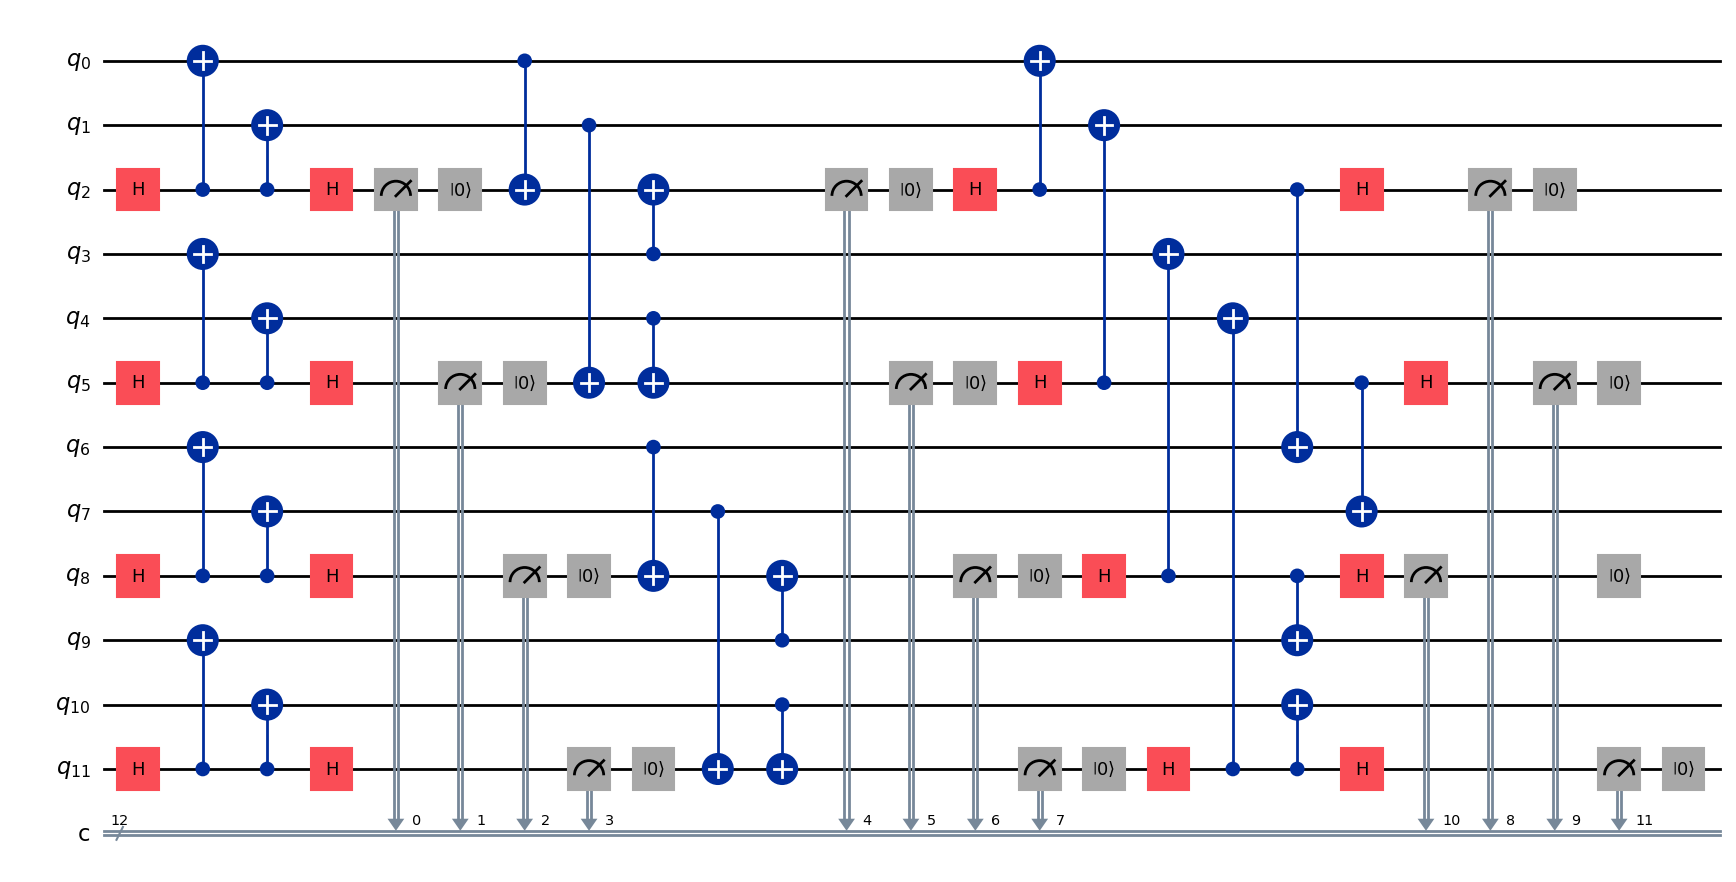

In [81]:
circ.draw("mpl", fold=-1)

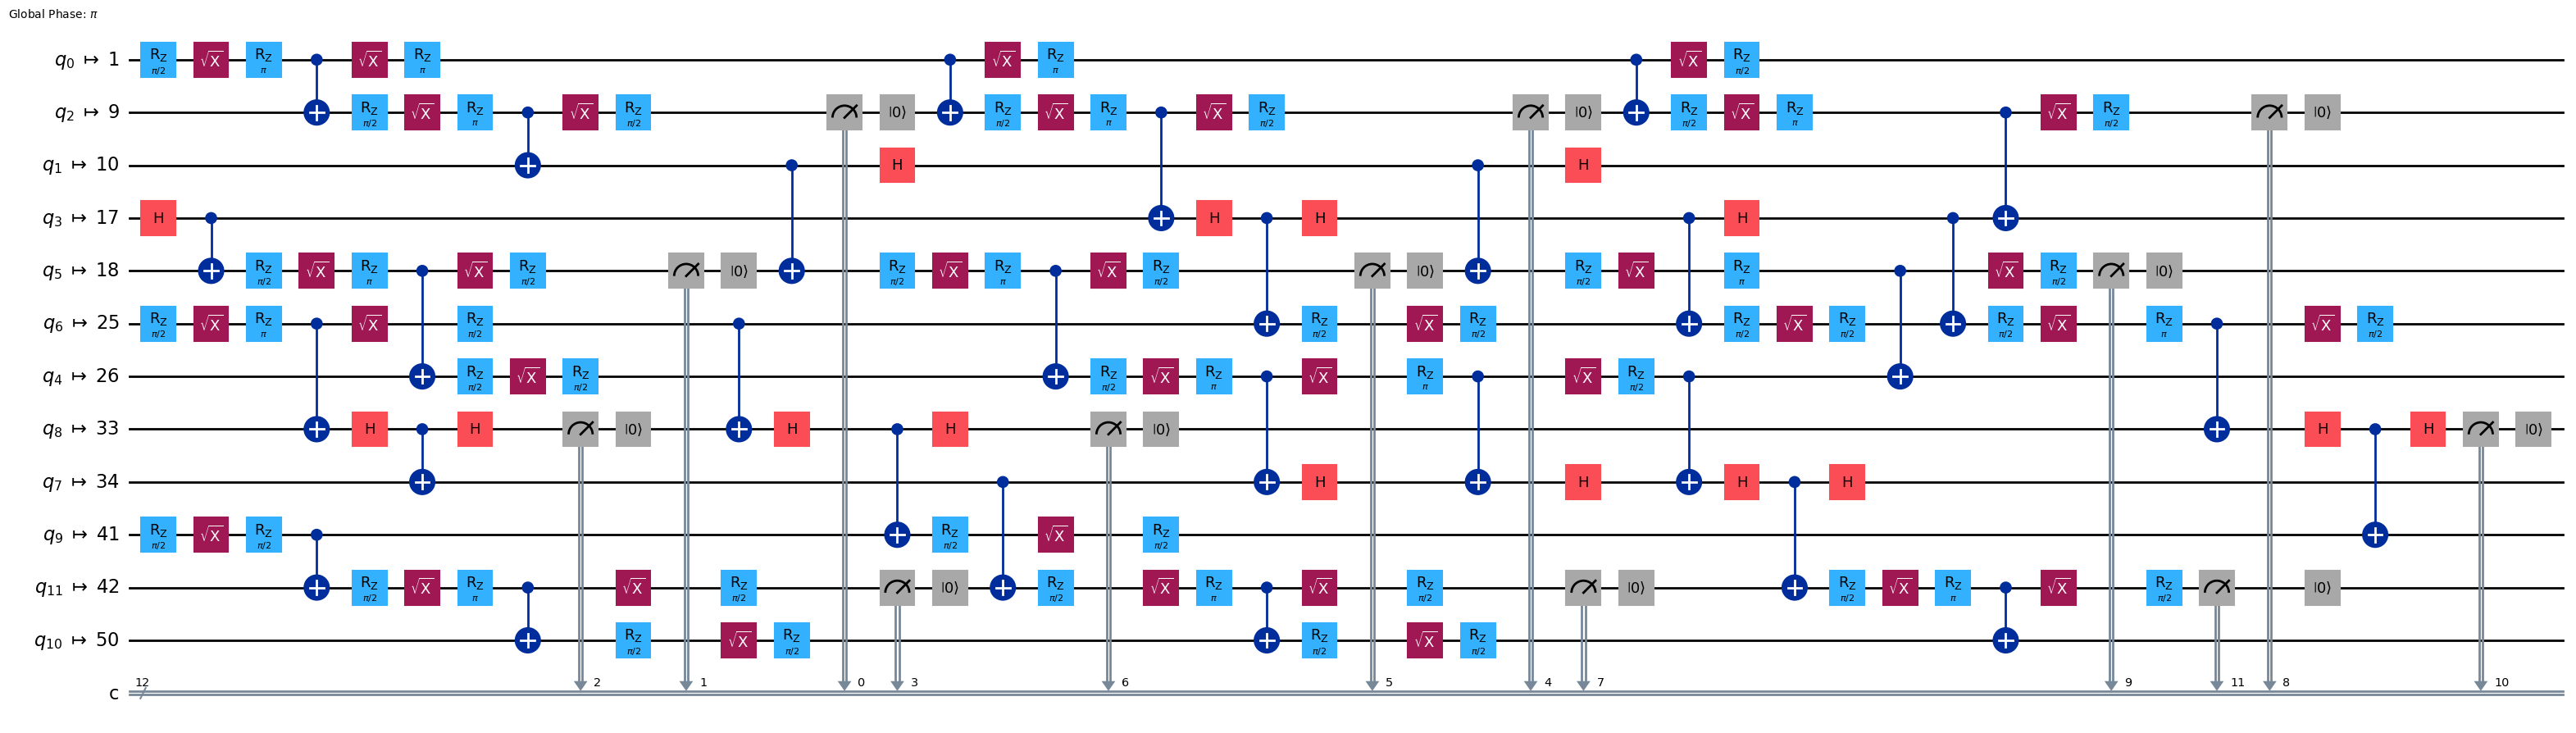

In [83]:
transpiled_circ.draw("mpl", idle_wires=False, fold=-1)

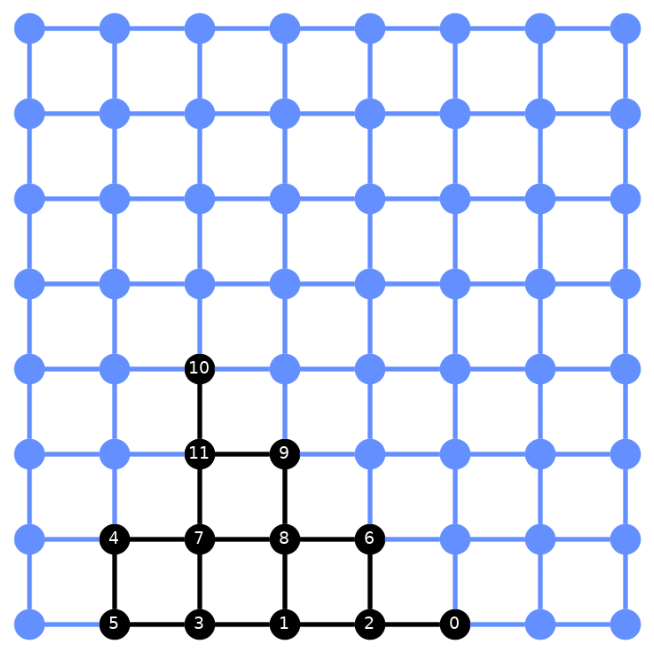

In [72]:
from qiskit.visualization import plot_circuit_layout
 
plot_circuit_layout(
    transpiled_circ, backend_grid, qubit_coordinates=coordinates
)

## For testing

In [88]:
def dynamic_range(i, n):
    start = (i - 1) * n
    end = start + n
    return list(range(start, end))



In [89]:
circ.num_clbits

12

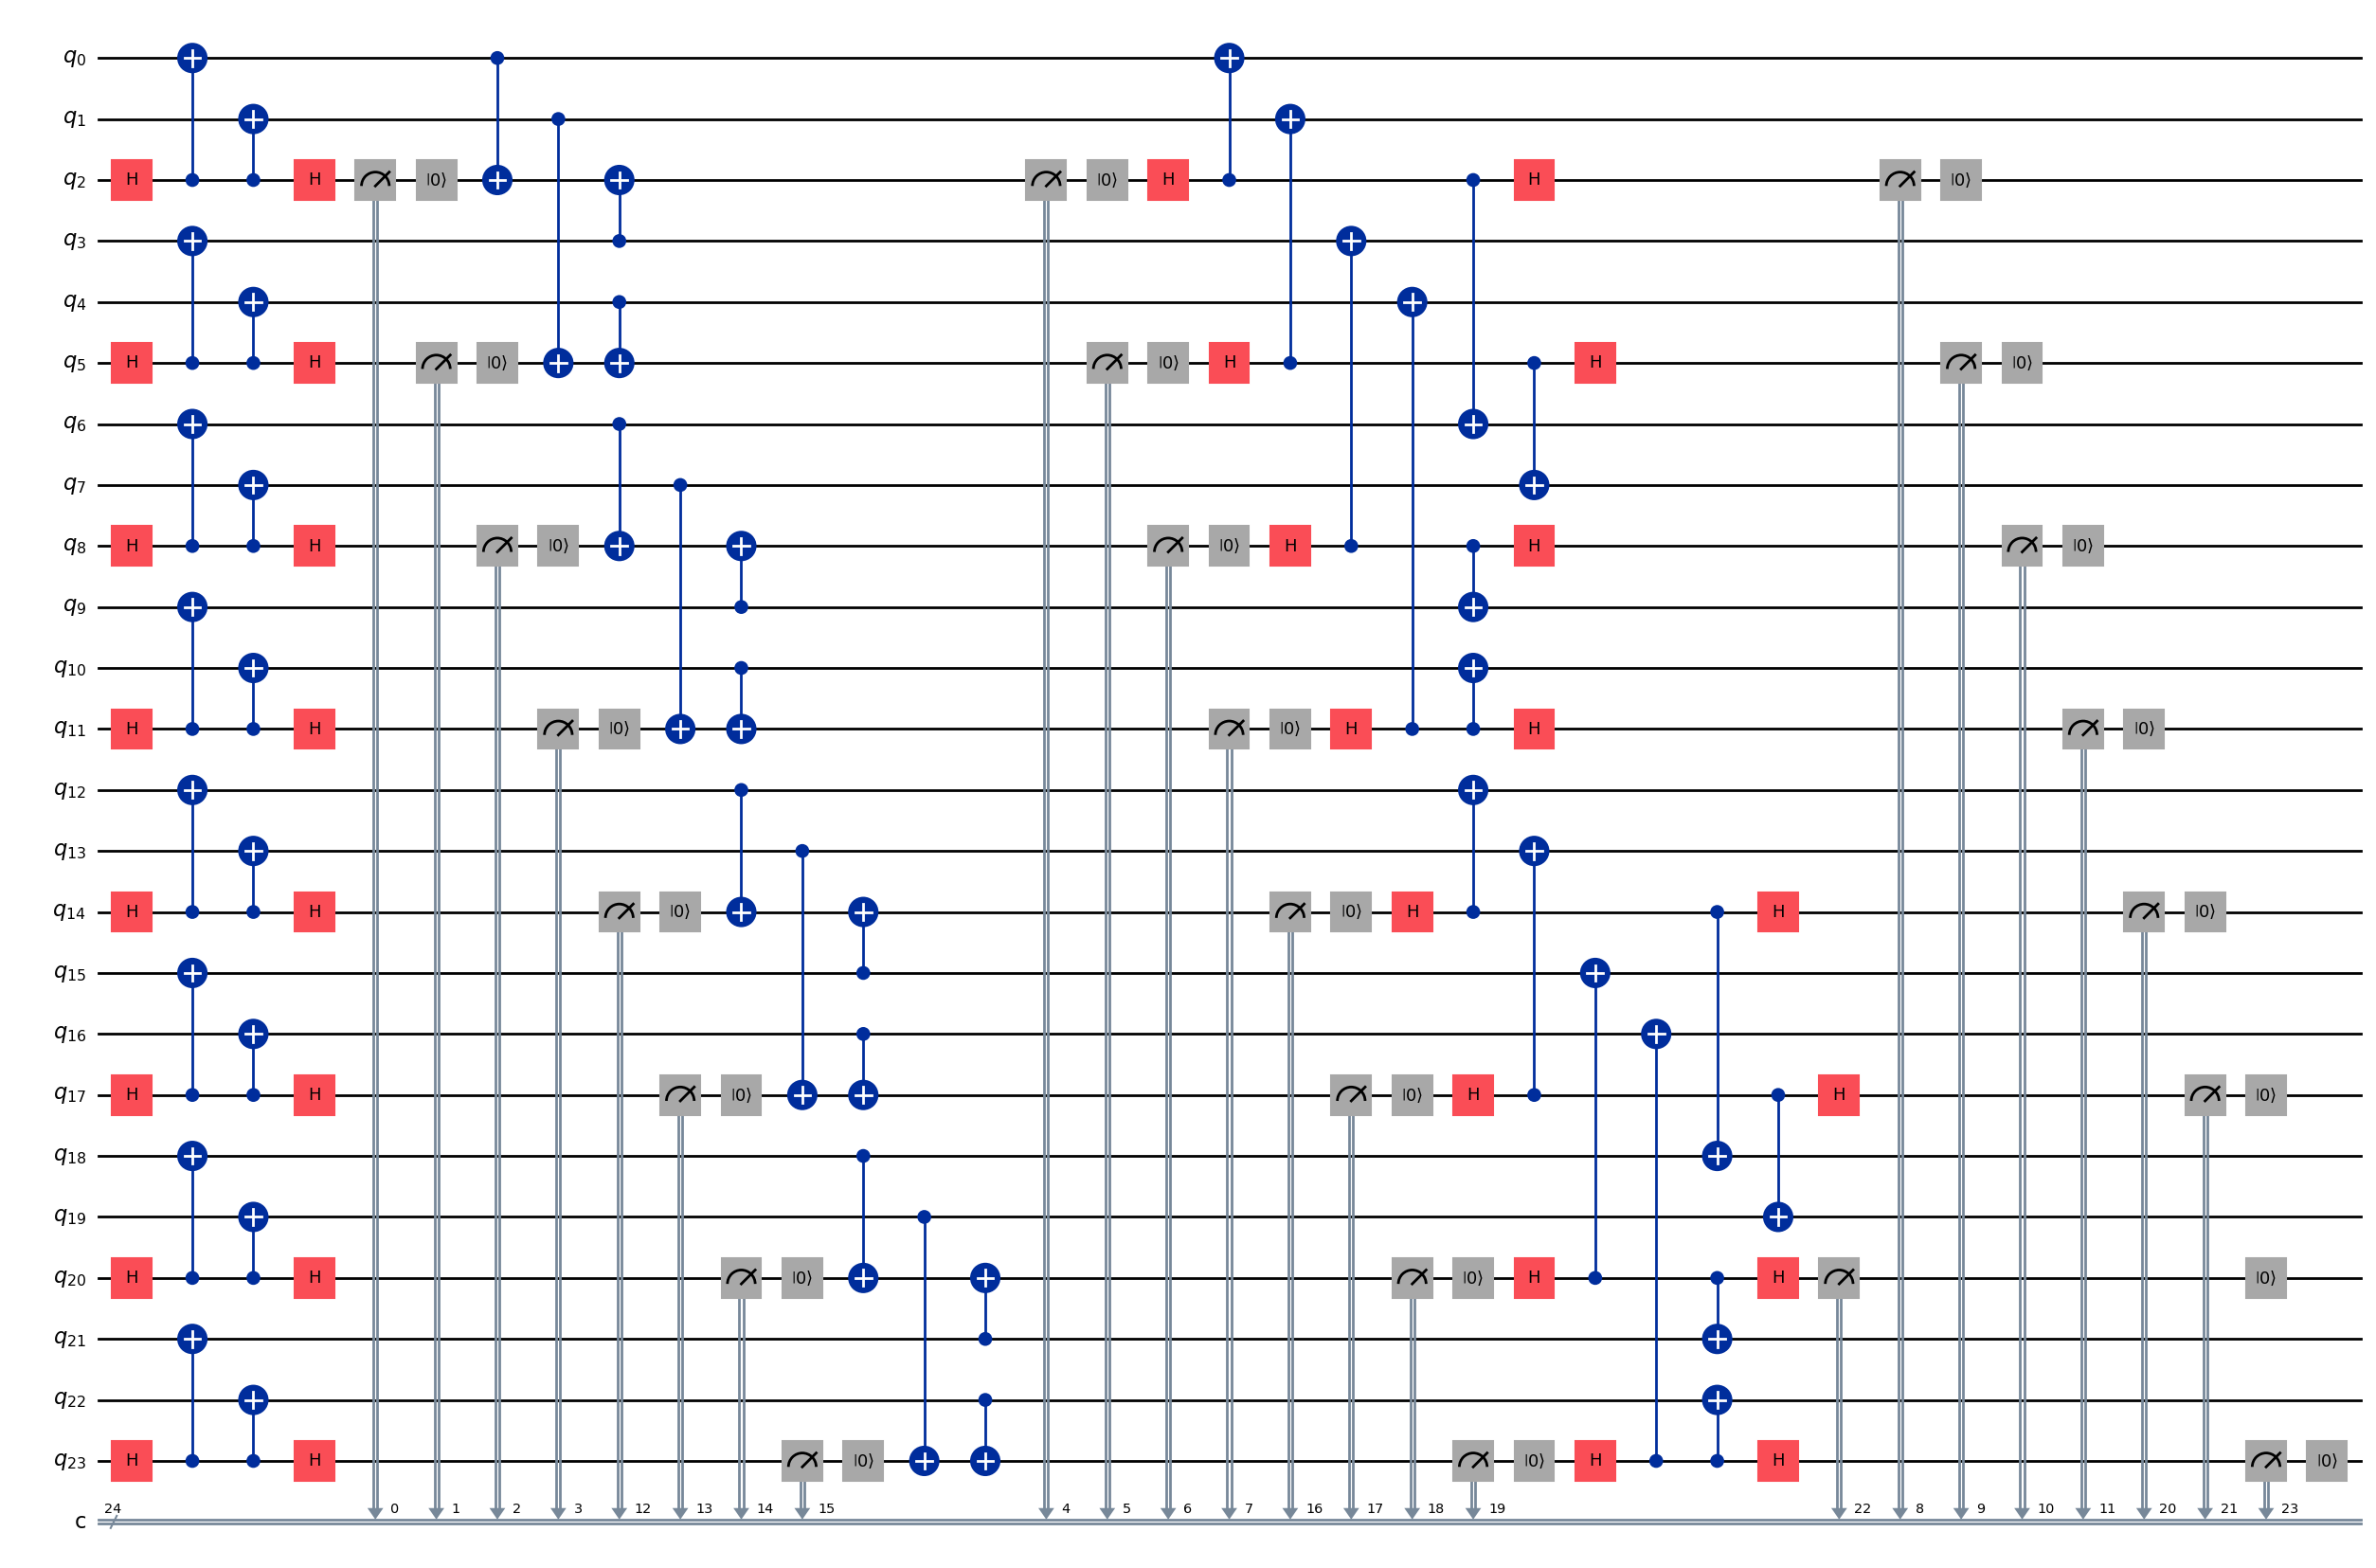

In [91]:
circ = polar_circuits_x[3]
inst = circ.to_instruction()
circuit_num_qubits = circ.num_qubits
backend_num_qubits = backend_grid.num_qubits

multi_num_circuit = backend_num_qubits // circuit_num_qubits


n = circuit_num_qubits

multi_num_circuit = 2

n_qubit = circuit_num_qubits * multi_num_circuit
n_clbit = circuit_num_qubits * multi_num_circuit

multi_circ = QuantumCircuit(n_qubit, n_clbit)

for i in range(1, multi_num_circuit+1):  

    idx_range = dynamic_range(i, n)
    multi_circ.append(inst,idx_range,idx_range)
    
multi_circ.decompose().draw("mpl", idle_wires=False, fold=-1)

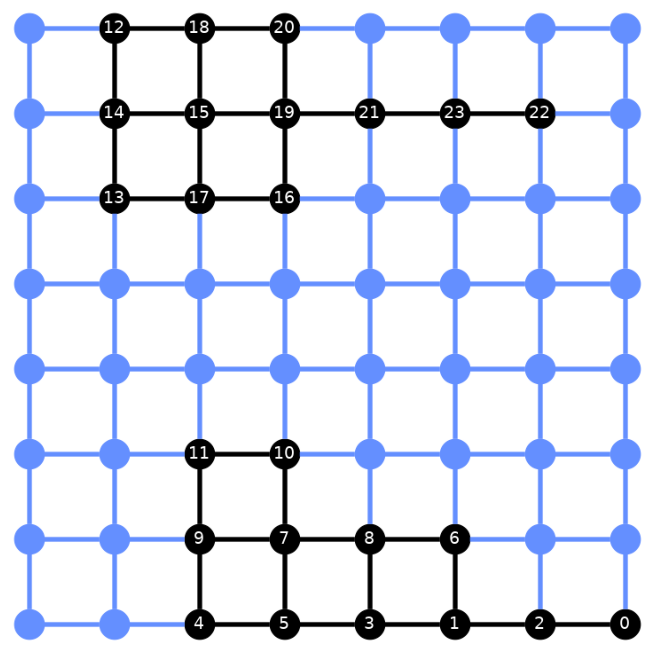

In [92]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_grid)
transpiled_circ = pm.run(multi_circ)
op_counts = transpiled_circ.count_ops()
 

plot_circuit_layout(transpiled_circ, backend_grid, qubit_coordinates=coordinates)

In [93]:
print("# qubits", transpiled_circ.num_qubits)
print("# ancilla", transpiled_circ.num_ancillas)
print("# ancilla", transpiled_circ.ancillas)

# qubits 64
# ancilla 0
# ancilla []


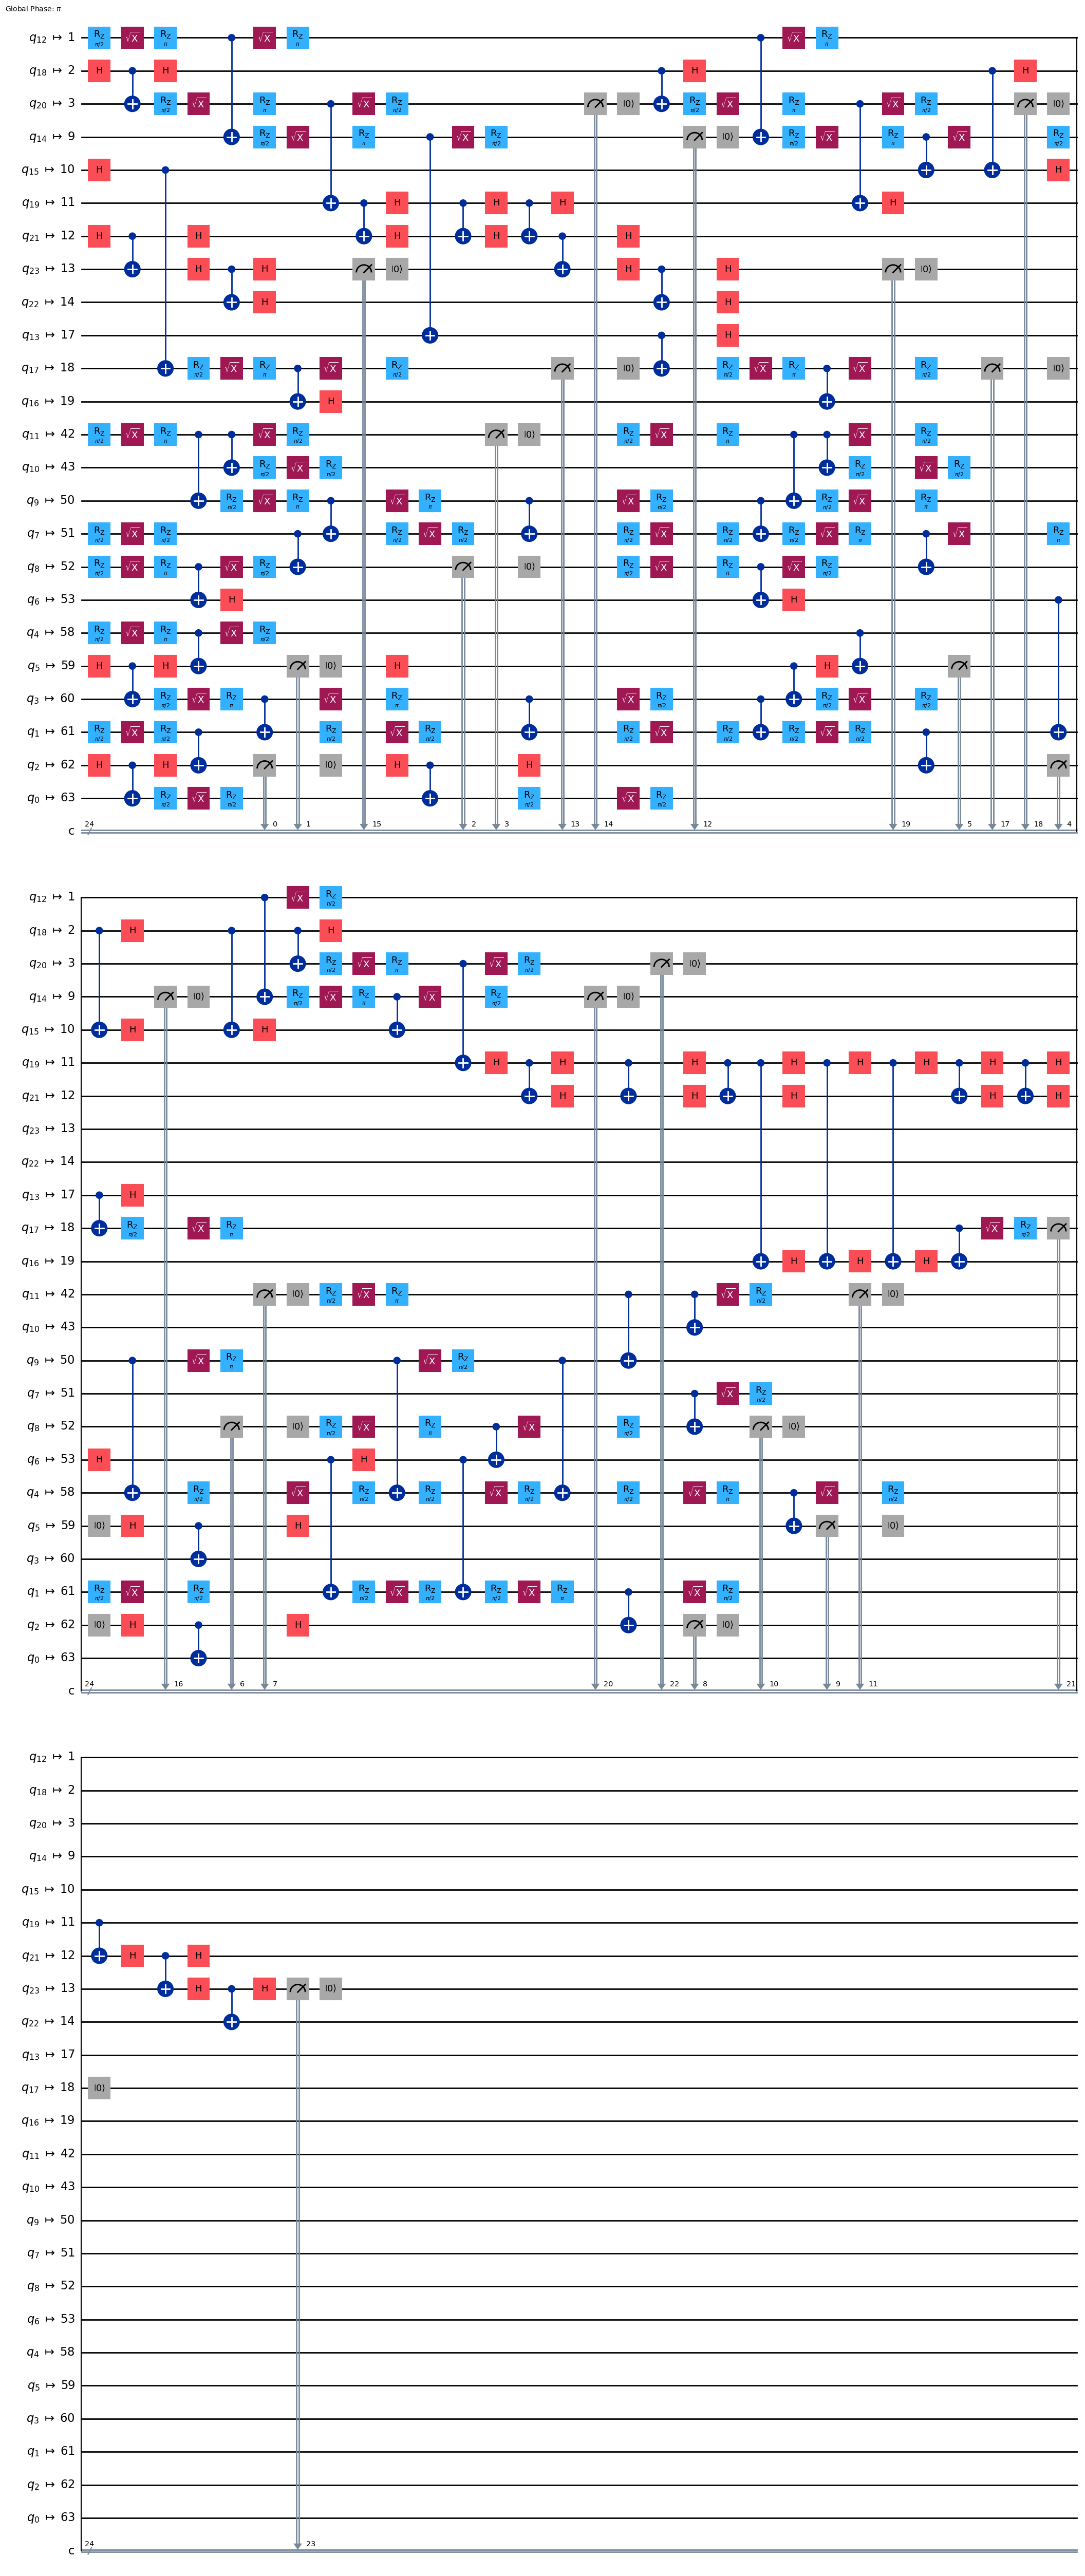

In [94]:
transpiled_circ.draw("mpl", idle_wires=False, fold=30)

In [26]:
## End testing

In [22]:
list_2q_z5 = []
list_depth_z5 = []
list_2q_depth_z5 = []

rows = 10
cols = 10
backend_grid = FakeGridBackend(rows, cols)

pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend_grid
)

for i in range(3,7):
    circuit = polar_circuits[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "cx"):
            list_2q_z5.append(op[1])
    list_depth_z5.append(transpiled.depth())
    list_2q_depth_z5.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))

for i in range(3,7):
    circuit = polar_circuits_x[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "cx"):
            list_2q_z5.append(op[1])
    list_depth_z5.append(transpiled.depth())
    list_2q_depth_z5.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))

/tmp/ipykernel_10143/3236360873.py:21: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  list_2q_depth_z5.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))
/tmp/ipykernel_10143/3236360873.py:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  list_2q_depth_z5.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))


In [23]:
df_polar = pd.DataFrame({
        'circuit_name': list_circuit_name,
        'base_2q': list_2q,
        'z4_2q': list_2q_z4,
        'z5_2q': list_2q_z5,
    
        'base_depth': list_depth,
        'z4_depth': list_depth_z4,
        'z5_depth': list_depth_z5,
    
        'base_2q_depth': list_2q_depth,
        'z4_2q_depth': list_2q_depth_z4,
        'z5_2q_depth': list_2q_depth_z5,
    })

In [24]:
df_polar

,circuit_name,base_2q,z4_2q,z5_2q,base_depth,z4_depth,z5_depth,base_2q_depth,z4_2q_depth,z5_2q_depth
0,polar_z_n3,8,8,8,6,15,17,2,2,2
1,polar_z_n4,64,212,118,20,234,110,8,55,26
2,polar_z_n5,64,112,64,12,74,36,4,17,4
3,polar_z_n6,384,2869,1602,30,1381,626,12,353,203
4,polar_x_n3,24,52,30,6,93,52,2,23,12
5,polar_x_n4,48,118,66,20,102,61,8,22,12
6,polar_x_n5,160,777,457,12,514,248,4,123,71
7,polar_x_n6,320,1816,1077,30,747,451,12,181,133


## Fake triangular lattice backend (z = 7)

In [25]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

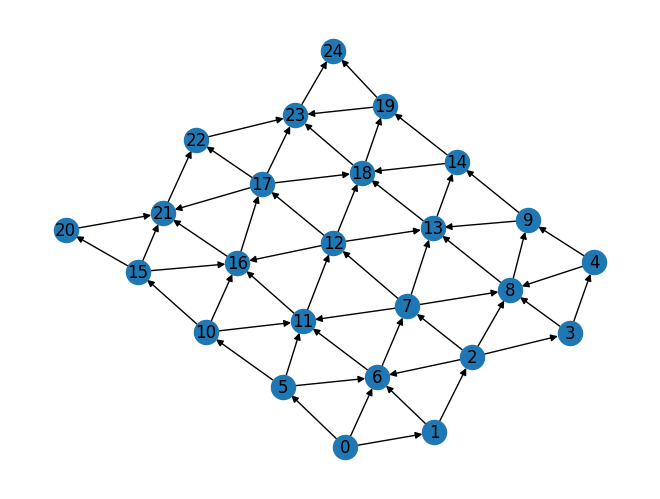

In [26]:
g = rx.generators.directed_grid_graph(5, 5)
g.add_edge(0,6,1)
g.add_edge(2,6,1)
g.add_edge(2,8,1)
g.add_edge(4,8,1)

g.add_edge(5,11,1)
g.add_edge(7,11,1)
g.add_edge(7,13,1)
g.add_edge(9,13,1)

g.add_edge(10,16,1)
g.add_edge(12,16,1)
g.add_edge(12,18,1)
g.add_edge(14,18,1)

g.add_edge(15,21,1)
g.add_edge(17,21,1)
g.add_edge(17,23,1)
g.add_edge(19,23,1)



mpl_draw(g, with_labels=True)

In [27]:
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

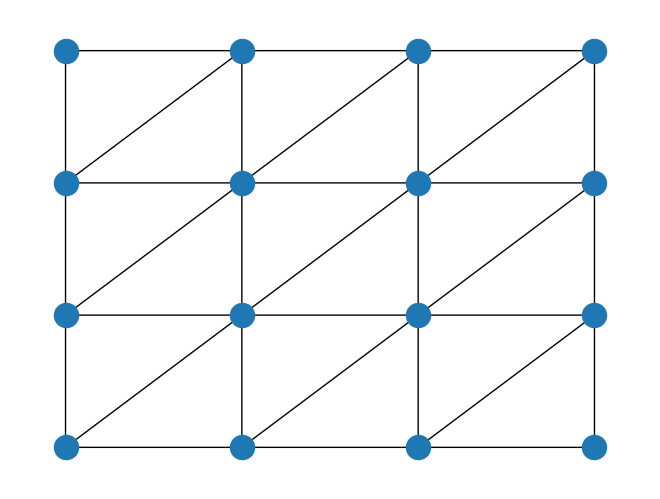

In [28]:
rows = 4
cols = 4
boundary_condition = BoundaryCondition.OPEN

triangular_lattice = TriangularLattice(rows=rows, cols=cols)

triangular_lattice.draw()

In [29]:
self_root_edge = []
g = triangular_lattice.graph
for root_edge in g.edge_list():
    if root_edge[0] == root_edge[1]:
        self_root_edge.append(root_edge)

for e in self_root_edge:
    g.remove_edge(e[0],e[1])

for root_edge in g.edge_list():
    print(root_edge)

(0, 1)
(0, 4)
(0, 5)
(4, 5)
(4, 8)
(4, 9)
(8, 9)
(8, 12)
(8, 13)
(12, 13)
(1, 2)
(1, 5)
(1, 6)
(5, 6)
(5, 9)
(5, 10)
(9, 10)
(9, 13)
(9, 14)
(13, 14)
(2, 3)
(2, 6)
(2, 7)
(6, 7)
(6, 10)
(6, 11)
(10, 11)
(10, 14)
(10, 15)
(14, 15)
(3, 7)
(7, 11)
(11, 15)


In [30]:
class FakeTriangularLatticeBackend(BackendV2):
    """Fake traingular lattice backend."""
 
    def __init__(self, rows=3, cols=3):

        self_root_edge = []
        
        super().__init__(name="Fake triangular lattice backend")
        triangular_lattice = TriangularLattice(rows=rows, cols=cols)
        g = triangular_lattice.graph
        for root_edge in g.edge_list():
            if root_edge[0] == root_edge[1]:
                self_root_edge.append(root_edge)
        
        for e in self_root_edge:
            g.remove_edge(e[0],e[1])
        
        self._graph = g
        num_qubits = len(self._graph)
        self._target = Target(
            "Fake traingular lattice backend", num_qubits=num_qubits
        )
        number_of_chips = 1
 
        # Generate instruction properties for single qubit gates and a measurement, delay,
        #  and reset operation to every qubit in the backend.
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
 
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1),
                duration=rng.uniform(1e-8, 9e-7),
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)
 
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        
        # Add chip local 2q gate which is CX
        cx_props = {}
        for i in range(number_of_chips):
            for root_edge in self._graph.edge_list():
                # print(root_edge)
                edge = (root_edge[0], root_edge[1])
                cx_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3),
                    duration=rng.uniform(1e-8, 9e-7),
                )
        self._target.add_instruction(CXGate(), cx_props)
 
 
    @property
    def target(self):
        return self._target
 
    @property
    def max_circuits(self):
        return None
 
    @property
    def graph(self):
        return self._graph
 
    @classmethod
    def _default_options(cls):
        return Options(shots=1024)
 
    def run(self, circuit, **kwargs):
        raise NotImplementedError(
            "This backend does not contain a run method"
        )

In [31]:
rows = 4
cols = 4
backend_triangular = FakeTriangularLatticeBackend(rows, cols)
 
 
target = backend_triangular.target
coupling_map_backend = target.build_coupling_map()

coordinates = []

for i in range(0,-1 * cols,-1):
    for j in range(rows):
        coordinates.append((i,j))
 
single_qubit_coordinates = []
total_qubit_coordinates = []
 
 
for coordinate in coordinates:
    total_qubit_coordinates.append(coordinate)
 
for coordinate in coordinates:
    total_qubit_coordinates.append(
        (-1 * coordinate[0] + 1, coordinate[1] + 4)
    )
 
for coordinate in coordinates:
    total_qubit_coordinates.append((coordinate[0], coordinate[1] + 8))
 
 
line_colors = ["#adaaab" for edge in coupling_map_backend.get_edges()]
ecr_edges = []
 
# Get tuples for the edges which have an ecr instruction attached
for instruction in target.instructions:
    if instruction[0].name == "ecr":
        ecr_edges.append(instruction[1])
 
for i, edge in enumerate(coupling_map_backend.get_edges()):
    if edge in ecr_edges:
        line_colors[i] = "#000000"

Fake triangular lattice backend


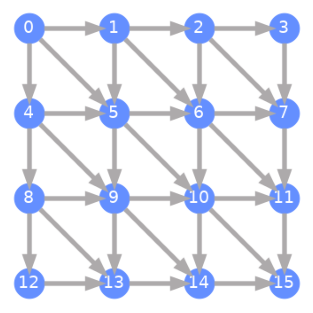

In [32]:
print(backend_triangular.name)
plot_gate_map(
    backend_triangular,
    plot_directed=True,
    qubit_coordinates=coordinates,
    line_color=line_colors,
)

In [33]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
circ = polar_circuits[3]
op_counts = circ.count_ops()
 
print("Pre-Transpilation: ")
print(f"CX gates: {op_counts['cx']}")
print(f"H gates: {op_counts['h']}")
print("\n", 30 * "#", "\n")
 
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_triangular)
transpiled_circ = pm.run(circ)
op_counts = transpiled_circ.count_ops()
 
print("Post-Transpilation: ")
# print(f"CZ gates: {op_counts['cz']}")
# print(f"ECR gates: {op_counts['ecr']}")
print(f"CX gates: {op_counts['cx']}")
print(f"SX gates: {op_counts['sx']}")
print(f"RZ gates: {op_counts['rz']}")



Pre-Transpilation: 
CX gates: 8
H gates: 8

 ############################## 

Post-Transpilation: 
CX gates: 8
SX gates: 24
RZ gates: 36


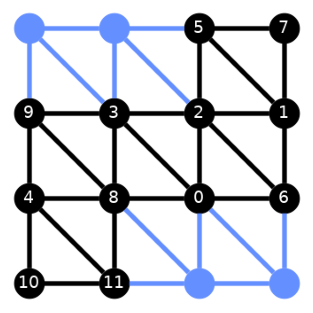

In [34]:
from qiskit.visualization import plot_circuit_layout
 
plot_circuit_layout(
    transpiled_circ, backend_triangular, qubit_coordinates=coordinates
)

In [35]:
list_2q_z7 = []
list_depth_z7 = []
list_2q_depth_z7 = []

rows = 10
cols = 10
backend_triangular = FakeTriangularLatticeBackend(rows, cols)

pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend_triangular
)

for i in range(3,7):
    circuit = polar_circuits[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "cx"):
            list_2q_z7.append(op[1])
    list_depth_z7.append(transpiled.depth())
    list_2q_depth_z7.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))

for i in range(3,7):
    circuit = polar_circuits_x[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "cx"):
            list_2q_z7.append(op[1])
    list_depth_z7.append(transpiled.depth())
    list_2q_depth_z7.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))

/tmp/ipykernel_10143/819278224.py:21: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  list_2q_depth_z7.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))
/tmp/ipykernel_10143/819278224.py:31: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  list_2q_depth_z7.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))


In [36]:
df_polar = pd.DataFrame({
        'circuit_name': list_circuit_name,
        'n': list_n,
        'logical': list_logical,
        'base_2q': list_2q,
        'z4_2q': list_2q_z4,
        'z5_2q': list_2q_z5,
        'z7_2q': list_2q_z7,
    
        'base_depth': list_depth,
        'z4_depth': list_depth_z4,
        'z5_depth': list_depth_z7,
        'z7_depth': list_depth_z7,
    
        'base_2q_depth': list_2q_depth,
        'z4_2q_depth': list_2q_depth_z4,
        'z5_2q_depth': list_2q_depth_z5,
        'z7_2q_depth': list_2q_depth_z7,
    })

In [37]:
df_polar

,circuit_name,n,logical,base_2q,z4_2q,z5_2q,z7_2q,base_depth,z4_depth,z5_depth,z7_depth,base_2q_depth,z4_2q_depth,z5_2q_depth,z7_2q_depth
0,polar_z_n3,3,0,8,8,8,8,6,15,19,19,2,2,2,2
1,polar_z_n4,4,0,64,212,118,92,20,234,161,161,8,55,26,32
2,polar_z_n5,5,0,64,112,64,64,12,74,38,38,4,17,4,4
3,polar_z_n6,6,0,384,2869,1602,1329,30,1381,603,603,12,353,203,195
4,polar_x_n3,3,+,24,52,30,24,6,93,50,50,2,23,12,6
5,polar_x_n4,4,+,48,118,66,48,20,102,47,47,8,22,12,6
6,polar_x_n5,5,+,160,777,457,308,12,514,223,223,4,123,71,59
7,polar_x_n6,6,+,320,1816,1077,787,30,747,356,356,12,181,133,94


## Fake nine men morris backend (z = 9)

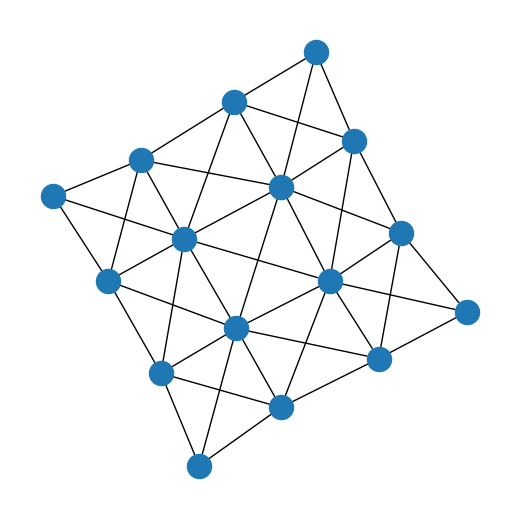

In [38]:
import rustworkx as rx
import matplotlib.pyplot as plt

def make_nine_men_morris_graph(size=3):
    # Create an empty graph
    graph = rx.PyGraph()
    
    # Add nodes (3x3 grid)
    node_positions = {}  # Store positions for visualization
    node_map = {}  # Map (x, y) positions to node indices
    
    for x in range(size):
        for y in range(size):
            node = graph.add_node((x, y))
            node_positions[node] = (x, -y)  # Matplotlib uses (x, -y) for better layout
            node_map[(x, y)] = node
    
    # Add edges (horizontal, vertical, and diagonal)
    for x in range(size):
        for y in range(size):
            if x < size - 1:  # Horizontal edges
                graph.add_edge(node_map[(x, y)], node_map[(x+1, y)], 1)
            if y < size - 1:  # Vertical edges
                graph.add_edge(node_map[(x, y)], node_map[(x, y+1)], 1)
            if x < size - 1 and y < size - 1:  # Diagonal edges
                graph.add_edge(node_map[(x, y)], node_map[(x+1, y+1)], 1)
                graph.add_edge(node_map[(x+1, y)], node_map[(x, y+1)], 1)
                pass
    
    return graph

graph = make_nine_men_morris_graph(4)
# Draw the graph
edges = [(edge[0], edge[1]) for edge in graph.edge_list()]
plt.figure(figsize=(5, 5))
mpl_draw(graph)
plt.show()


In [39]:
graph

In [40]:
class FakeNineManMorrisBackend(BackendV2):
    """Fake nine man morris backend."""
 
    def __init__(self, size=3):

        self_root_edge = []
        
        super().__init__(name="Fake nine man morris backend")
        
        self._graph = make_nine_men_morris_graph(size)
        num_qubits = len(self._graph)
        self._target = Target(
            "Fake nine man morris backend", num_qubits=num_qubits
        )
        number_of_chips = 1
 
        # Generate instruction properties for single qubit gates and a measurement, delay,
        #  and reset operation to every qubit in the backend.
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
 
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1),
                duration=rng.uniform(1e-8, 9e-7),
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)
 
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        
        # Add chip local 2q gate which is CX
        cx_props = {}
        for i in range(number_of_chips):
            for root_edge in self._graph.edge_list():
                # print(root_edge)
                edge = (root_edge[0], root_edge[1])
                cx_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3),
                    duration=rng.uniform(1e-8, 9e-7),
                )
        self._target.add_instruction(CXGate(), cx_props)
 
 
    @property
    def target(self):
        return self._target
 
    @property
    def max_circuits(self):
        return None
 
    @property
    def graph(self):
        return self._graph
 
    @classmethod
    def _default_options(cls):
        return Options(shots=1024)
 
    def run(self, circuit, **kwargs):
        raise NotImplementedError(
            "This backend does not contain a run method"
        )

In [41]:
size = 4
cols = 4
rows = 4
backend_nine = FakeNineManMorrisBackend(size)
 
 
target = backend_nine.target
coupling_map_backend = target.build_coupling_map()

coordinates = []

for i in range(0,-1 * cols,-1):
    for j in range(rows):
        coordinates.append((i,j))
 
single_qubit_coordinates = []
total_qubit_coordinates = []
 
 
for coordinate in coordinates:
    total_qubit_coordinates.append(coordinate)
 
for coordinate in coordinates:
    total_qubit_coordinates.append(
        (-1 * coordinate[0] + 1, coordinate[1] + 4)
    )
 
for coordinate in coordinates:
    total_qubit_coordinates.append((coordinate[0], coordinate[1] + 8))
 
 
line_colors = ["#adaaab" for edge in coupling_map_backend.get_edges()]
ecr_edges = []
 
# Get tuples for the edges which have an ecr instruction attached
for instruction in target.instructions:
    if instruction[0].name == "ecr":
        ecr_edges.append(instruction[1])
 
for i, edge in enumerate(coupling_map_backend.get_edges()):
    if edge in ecr_edges:
        line_colors[i] = "#000000"


In [42]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
circ = polar_circuits[3]
op_counts = circ.count_ops()
 
print("Pre-Transpilation: ")
print(f"CX gates: {op_counts['cx']}")
print(f"H gates: {op_counts['h']}")
print("\n", 30 * "#", "\n")
 
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_nine)
transpiled_circ = pm.run(circ)
op_counts = transpiled_circ.count_ops()
 
print("Post-Transpilation: ")
# print(f"CZ gates: {op_counts['cz']}")
# print(f"ECR gates: {op_counts['ecr']}")
print(f"CX gates: {op_counts['cx']}")
print(f"SX gates: {op_counts['sx']}")
print(f"RZ gates: {op_counts['rz']}")



Pre-Transpilation: 
CX gates: 8
H gates: 8

 ############################## 

Post-Transpilation: 
CX gates: 8
SX gates: 32
RZ gates: 48


Fake nine man morris backend


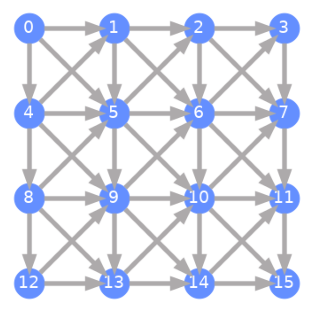

In [43]:
print(backend_nine.name)
plot_gate_map(
    backend_nine,
    plot_directed=True,
    qubit_coordinates=coordinates,
    line_color=line_colors,
)

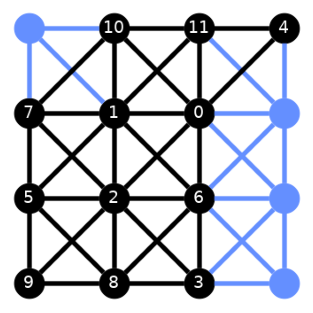

In [44]:
from qiskit.visualization import plot_circuit_layout
 
plot_circuit_layout(
    transpiled_circ, backend_nine, qubit_coordinates=coordinates
)


In [45]:
list_2q_z9 = []
list_depth_z9 = []
list_2q_depth_z9 = []

size = 10
backend_nine = FakeNineManMorrisBackend(size)

pm = generate_preset_pass_manager(
    optimization_level=3, backend=backend_nine
)

for i in range(3,7):
    circuit = polar_circuits[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "cx"):
            list_2q_z9.append(op[1])
    list_depth_z9.append(transpiled.depth())
    list_2q_depth_z9.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))

for i in range(3,7):
    circuit = polar_circuits_x[i]
    transpiled = pm.run(circuit)
    
    for op in transpiled.count_ops().items():
        if(op[0] == "cx"):
            list_2q_z9.append(op[1])
    list_depth_z9.append(transpiled.depth())
    list_2q_depth_z9.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))

/tmp/ipykernel_10143/100742327.py:20: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  list_2q_depth_z9.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))
/tmp/ipykernel_10143/100742327.py:30: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  list_2q_depth_z9.append(transpiled.depth(lambda gate: gate[0].name in ['cx']))


In [46]:
df_polar = pd.DataFrame({
        # 'circuit_name': list_circuit_name,
        'n': list_n,
        'logical': list_logical,
        'base_2q': list_2q,
        'z4_2q': list_2q_z4,
        'z5_2q': list_2q_z5,
        'z7_2q': list_2q_z7,
        'z9_2q': list_2q_z9,
    
        'base_depth': list_depth,
        'z4_depth': list_depth_z4,
        'z5_depth': list_depth_z7,
        'z7_depth': list_depth_z7,
        'z9_depth': list_depth_z9,
    
        'base_2q_depth': list_2q_depth,
        'z4_2q_depth': list_2q_depth_z4,
        'z5_2q_depth': list_2q_depth_z5,
        'z7_2q_depth': list_2q_depth_z7,
        'z9_2q_depth': list_2q_depth_z9,
    })

In [47]:
df = df_polar
df

,n,logical,base_2q,z4_2q,z5_2q,z7_2q,z9_2q,base_depth,z4_depth,z5_depth,z7_depth,z9_depth,base_2q_depth,z4_2q_depth,z5_2q_depth,z7_2q_depth,z9_2q_depth
0,3,0,8,8,8,8,8,6,15,19,19,17,2,2,2,2,2
1,4,0,64,212,118,92,85,20,234,161,161,85,8,55,26,32,22
2,5,0,64,112,64,64,64,12,74,38,38,36,4,17,4,4,4
3,6,0,384,2869,1602,1329,1073,30,1381,603,603,464,12,353,203,195,139
4,3,+,24,52,30,24,24,6,93,50,50,45,2,23,12,6,6
5,4,+,48,118,66,48,48,20,102,47,47,42,8,22,12,6,6
6,5,+,160,777,457,308,304,12,514,223,223,236,4,123,71,59,68
7,6,+,320,1816,1077,787,705,30,747,356,356,347,12,181,133,94,104


In [48]:
df = df_polar

def plot_result(type="2q"):
    # Convert 'n' to integer
    df["n"] = df["n"].astype(str)
    
    # Separate data based on logical values (0 and +)
    df_0 = df[df["logical"] == "0"]
    df_plus = df[df["logical"] == "+"]
    
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    # Define styles
    markers = ['o', 's', 'D', '^', 'v']
    colors = ['b', 'g', 'r', 'c', 'm']

    idx_range = range(2,7)
    # Plot for logical = "0"
    if type == "2q":
        idx_range = range(2,7)
        y_label = "#2Q gates"
    elif type == "depth":
        print("masuk")
        idx_range = range(7,12)
        y_label = "#depth"
    elif type == "2q_depth":
        idx_range = range(12,17)
        y_label = "#2Q gate depth"

    
    for i, col in enumerate(df.columns[idx_range]):  # Skip 'n' and 'logical'
        axes[0].plot(df_0["n"], df_0[col], marker=markers[i], linestyle="-", color=colors[i], label=col)
    
    axes[0].set_title("Logical = 0")
    axes[0].set_xlabel("code length")
    axes[0].set_ylabel(y_label)
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot for logical = "+"
    for i, col in enumerate(df.columns[idx_range]):
        axes[1].plot(df_plus["n"], df_plus[col], marker=markers[i], linestyle="-", color=colors[i], label=col)
    
    axes[1].set_title("Logical = +")
    axes[1].set_xlabel("code length")
    #axes[1].legend()
    axes[1].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


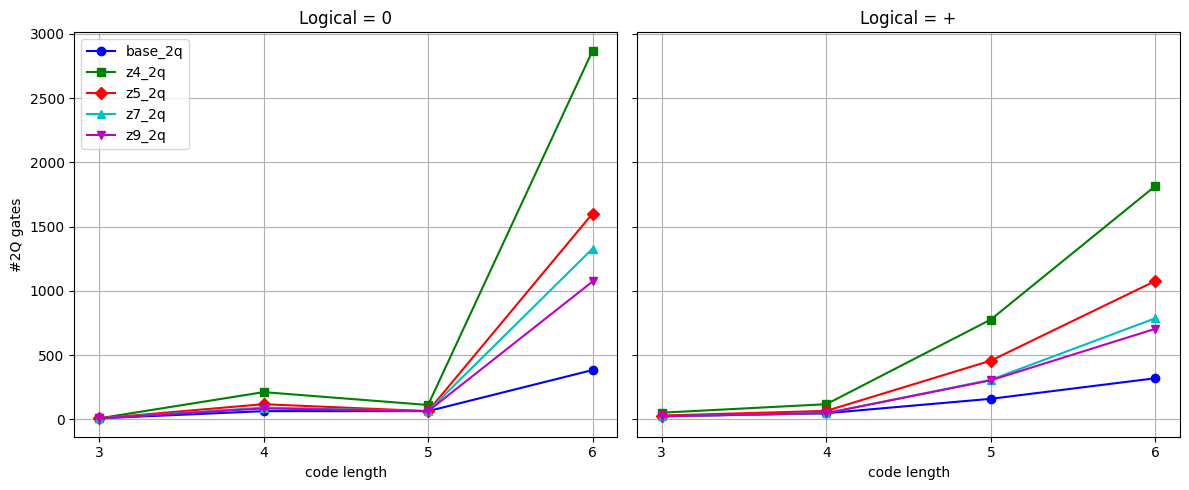

In [49]:
plot_result()

masuk


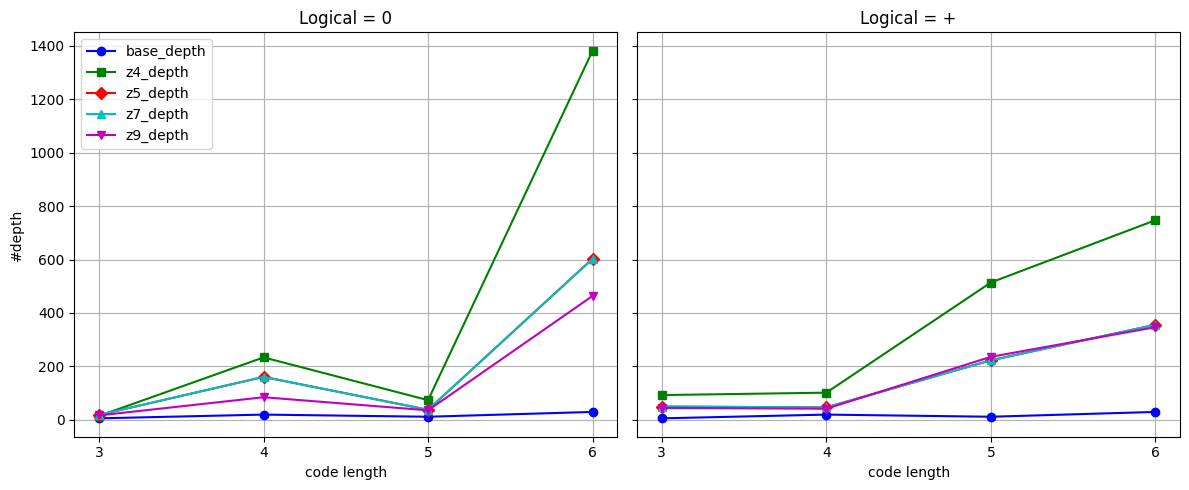

In [50]:
plot_result("depth")

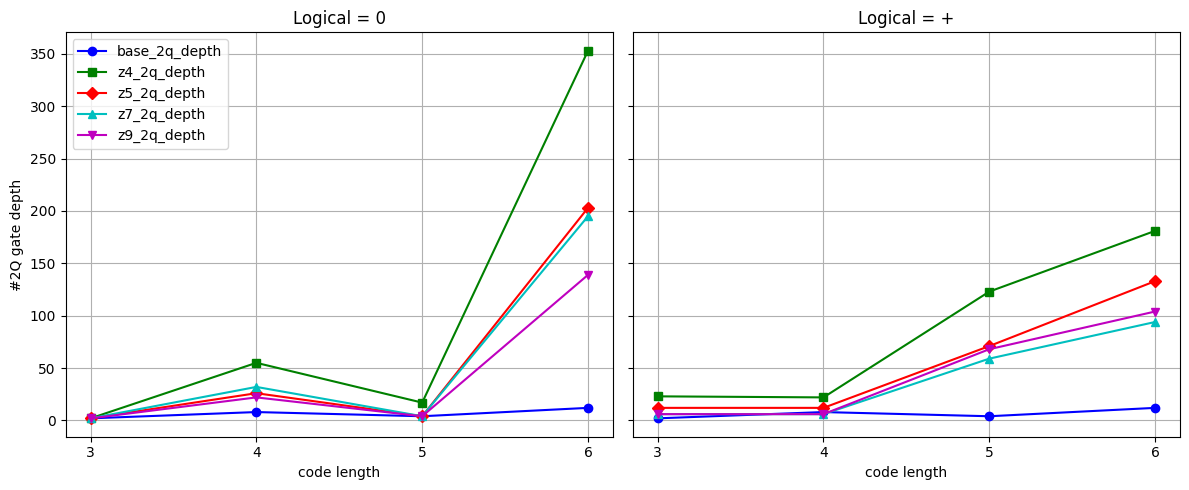

In [51]:
plot_result("2q_depth")

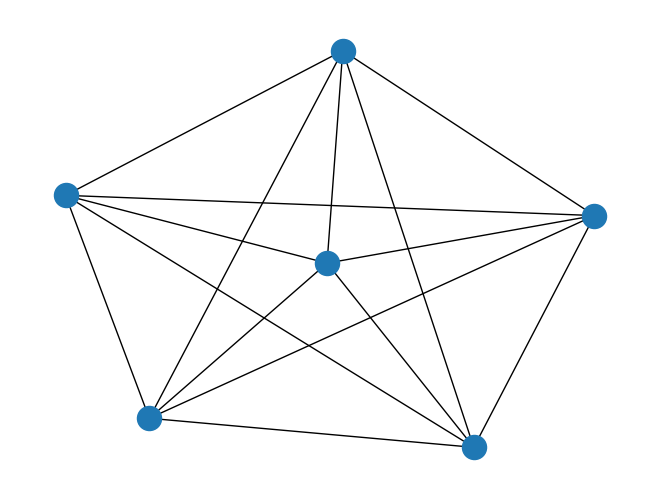

In [52]:
import rustworkx.generators
from rustworkx.visualization import mpl_draw

graph = rustworkx.generators.mesh_graph(6)
mpl_draw(graph)

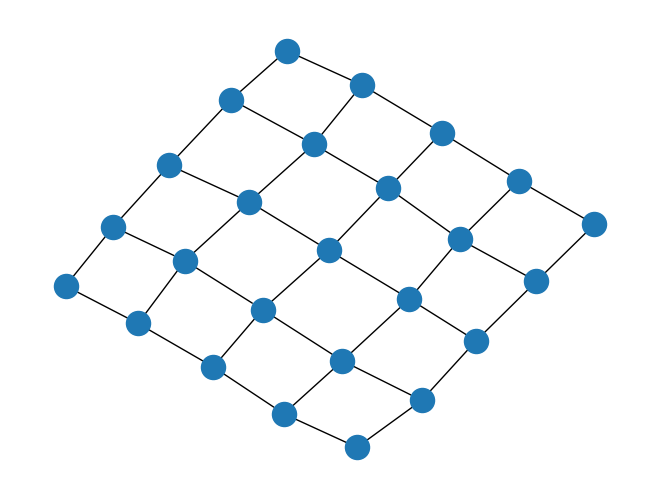

In [53]:
graph = rustworkx.generators.grid_graph(5, 5)
mpl_draw(graph)

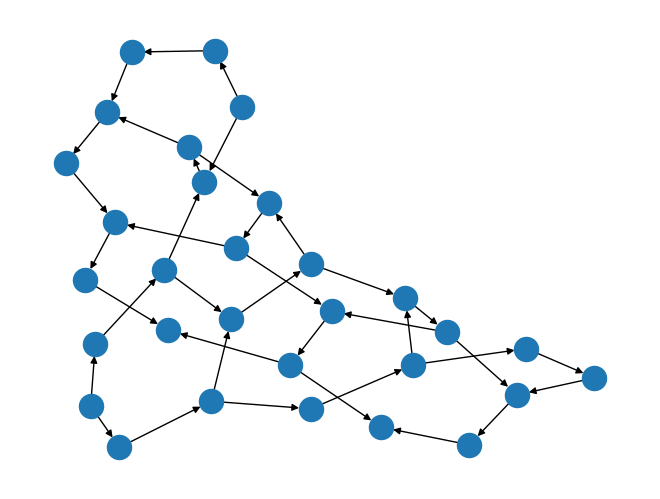

In [54]:
graph = rustworkx.generators.directed_hexagonal_lattice_graph(3, 3)
mpl_draw(graph)

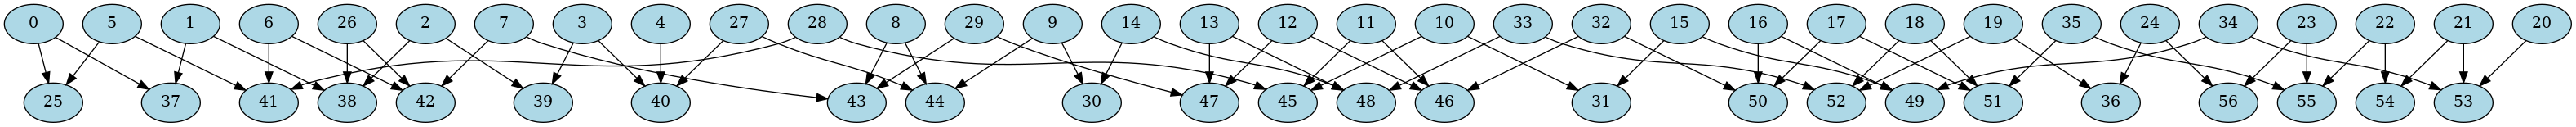

In [55]:
from rustworkx.visualization import graphviz_draw
graph = rustworkx.generators.directed_heavy_hex_graph(5)
graphviz_draw(graph, lambda node: dict(
        color='black', fillcolor='lightblue', style='filled'))

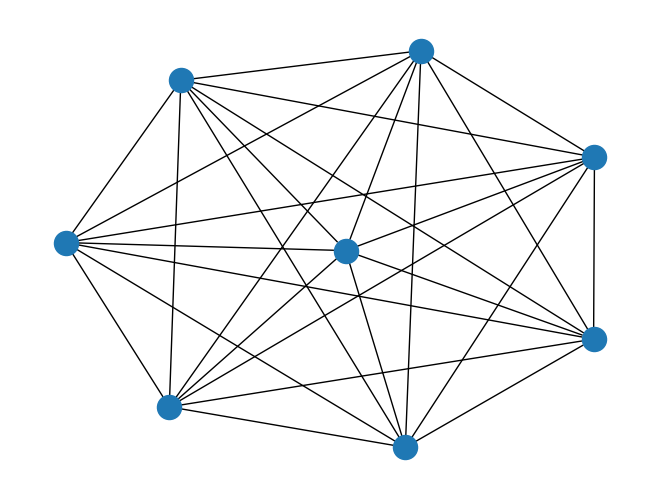

In [56]:
import rustworkx.generators
from rustworkx.visualization import mpl_draw

graph = rustworkx.generators.complete_graph(8)
mpl_draw(graph)

In [57]:
for i in range(0,-1 * 5,-1):
    print(i)

0
-1
-2
-3
-4
